# Dimensional Reduction: II

*Davide Gerosa (Milano-Bicocca)* 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 7.

This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.

---

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Back to the handwritten digits...

Let's revisit the digits sample and see what PCA, NMF, and ICA do for it.

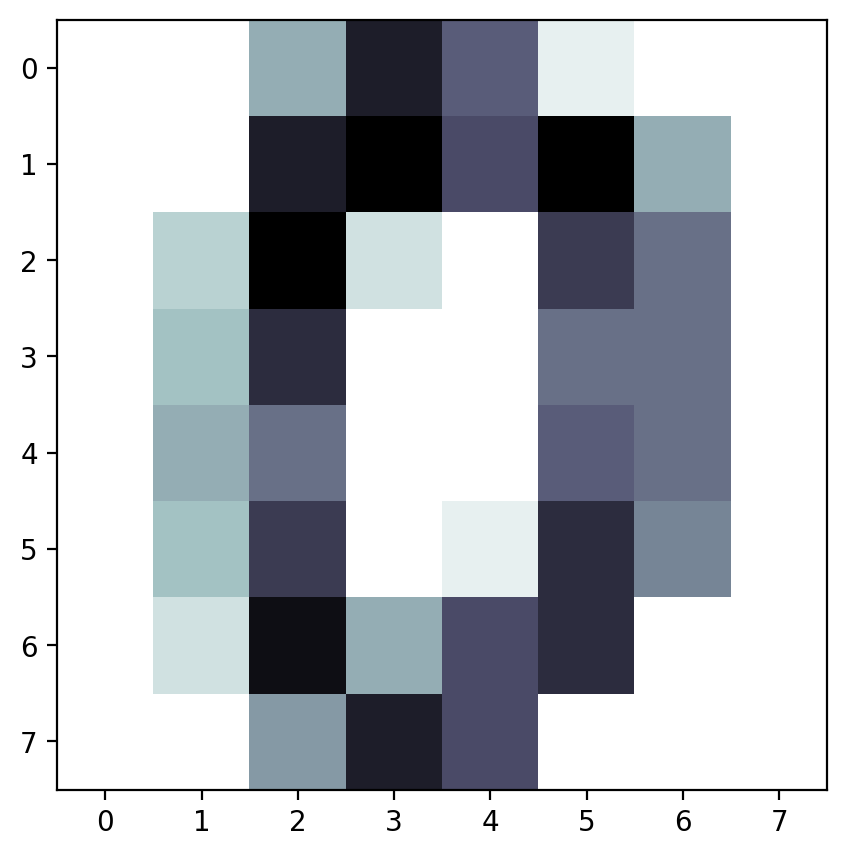

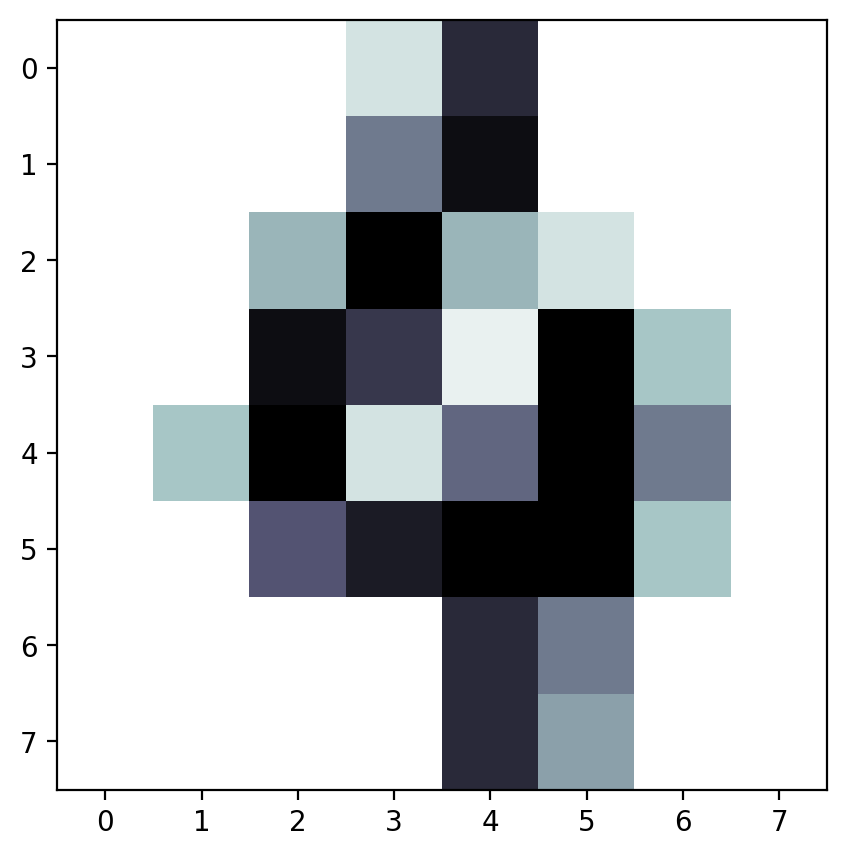

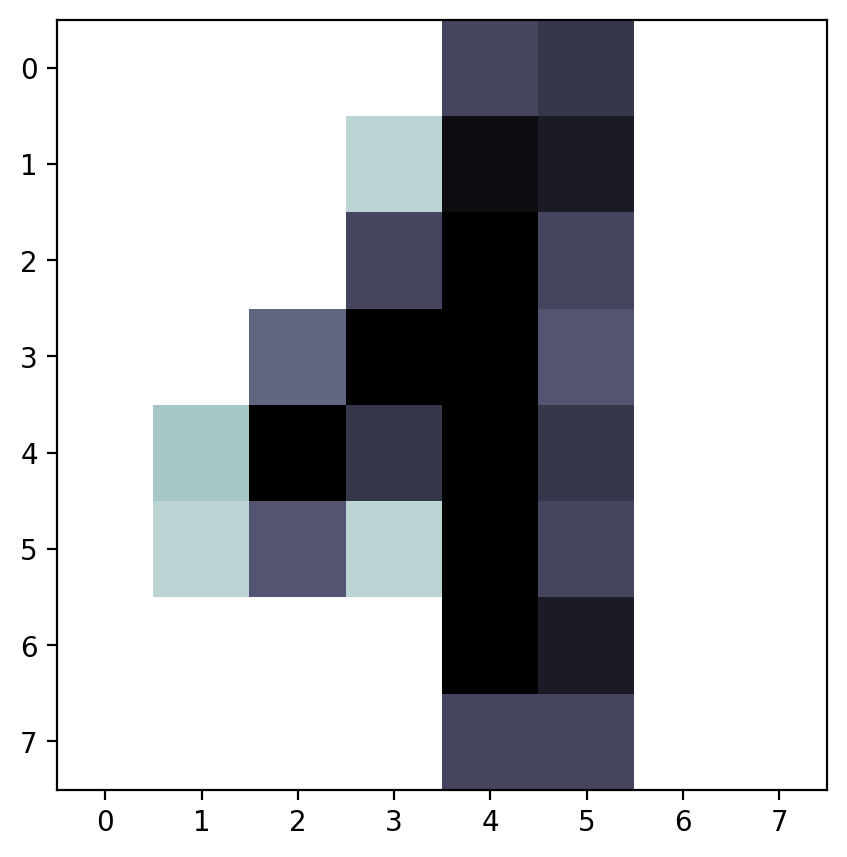

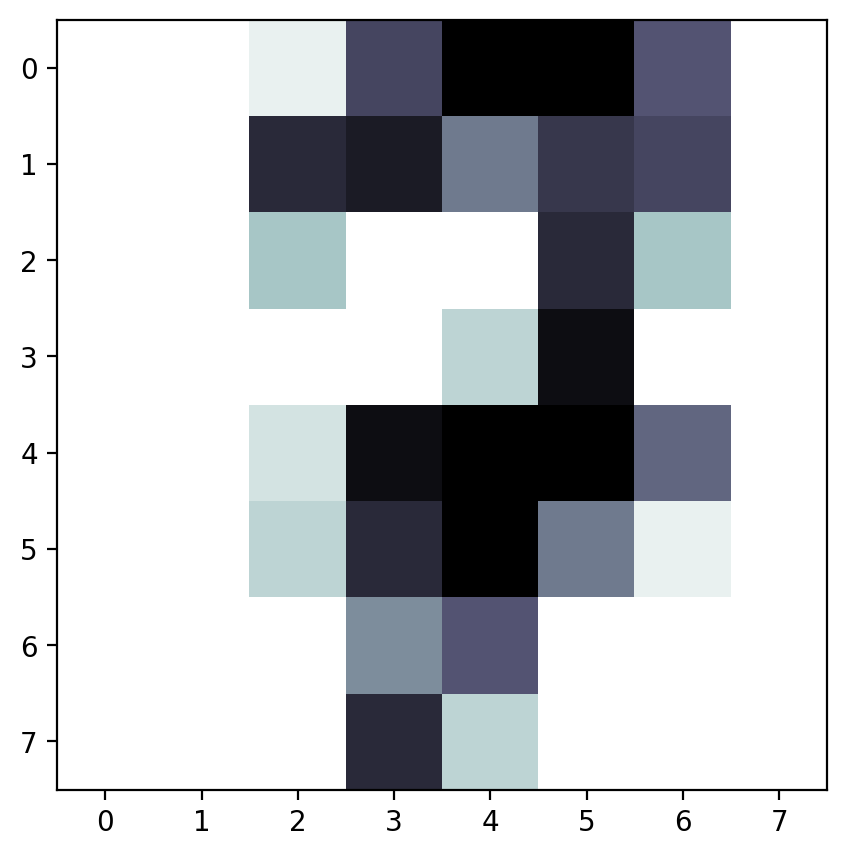

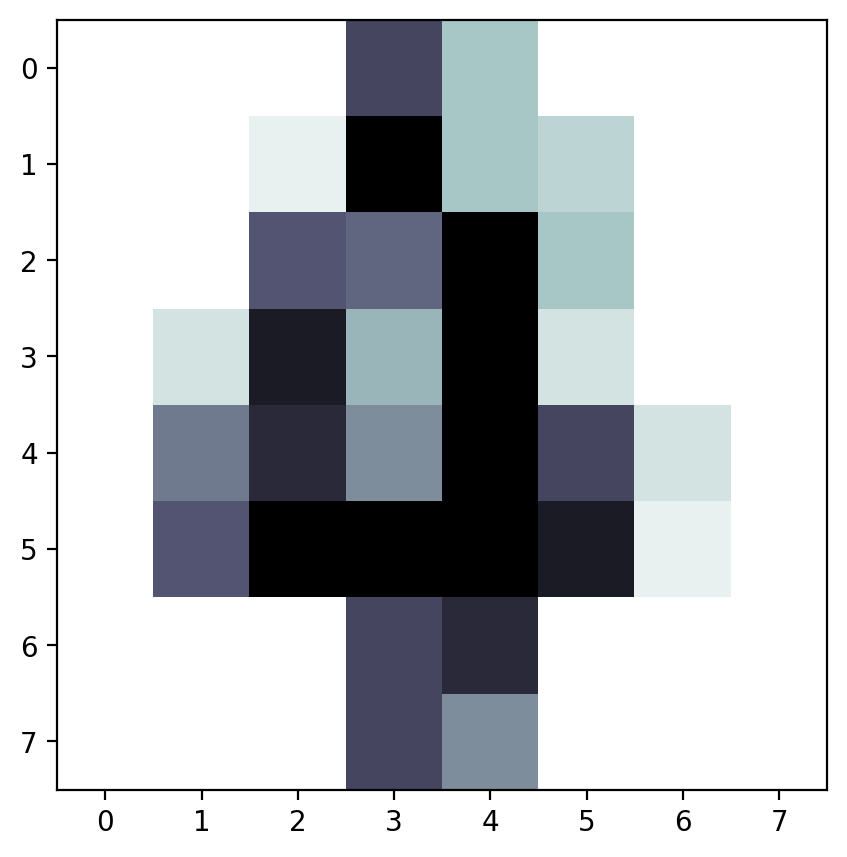

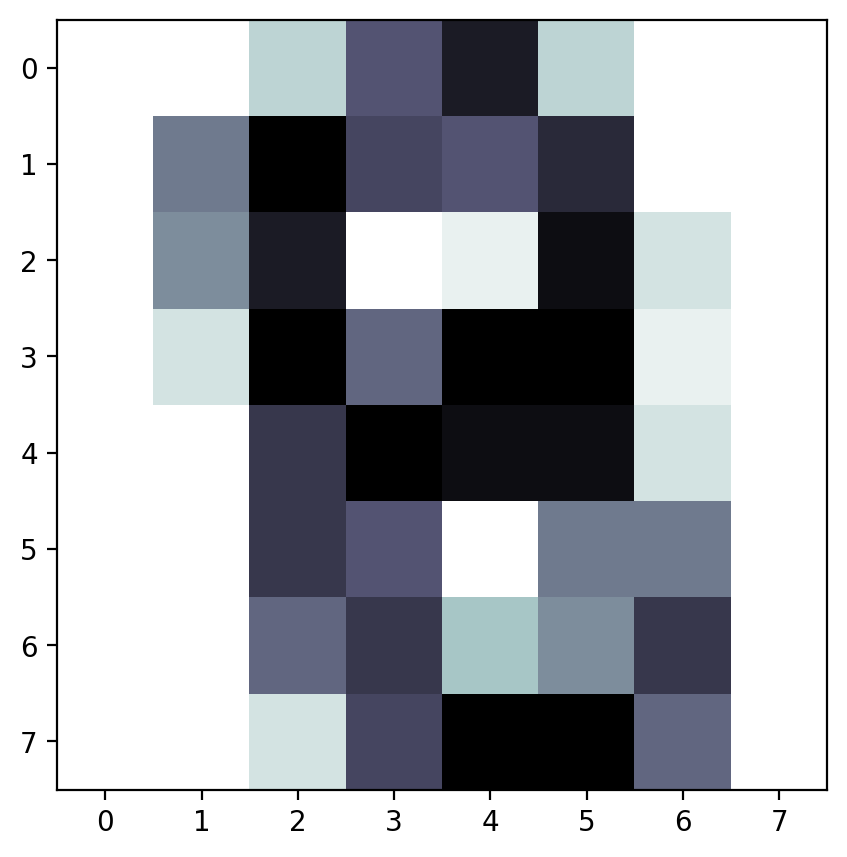

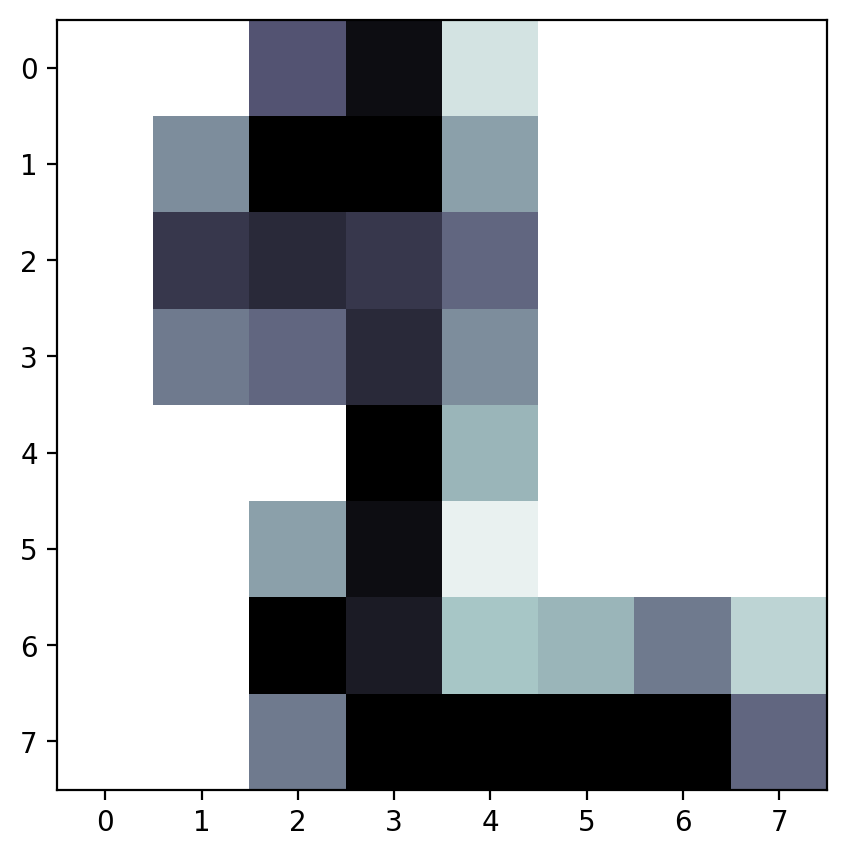

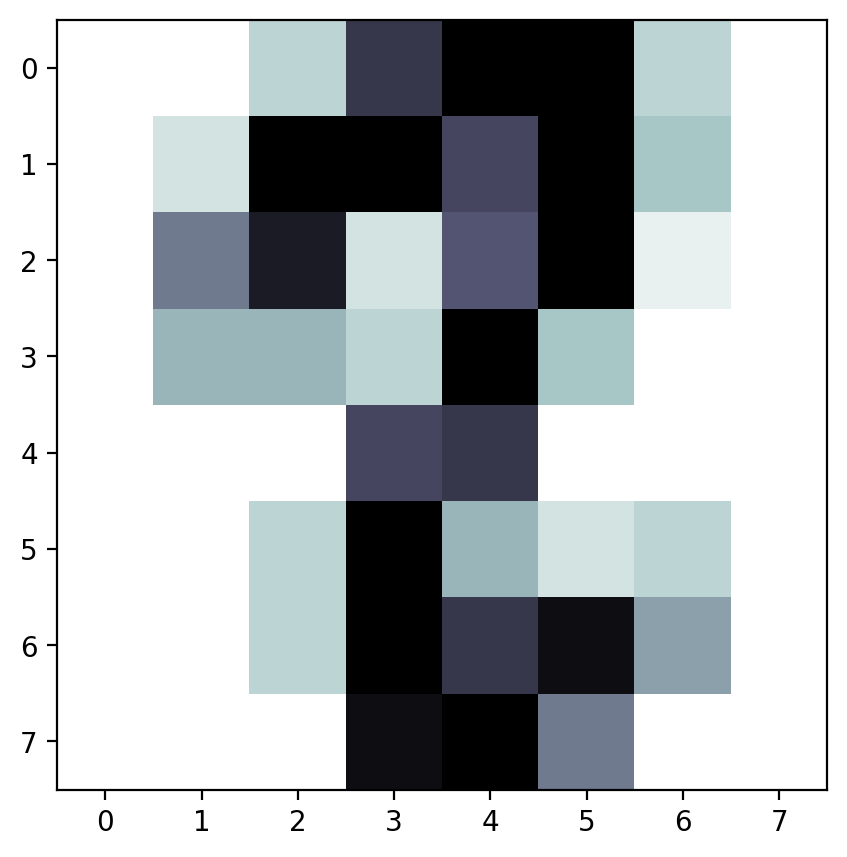

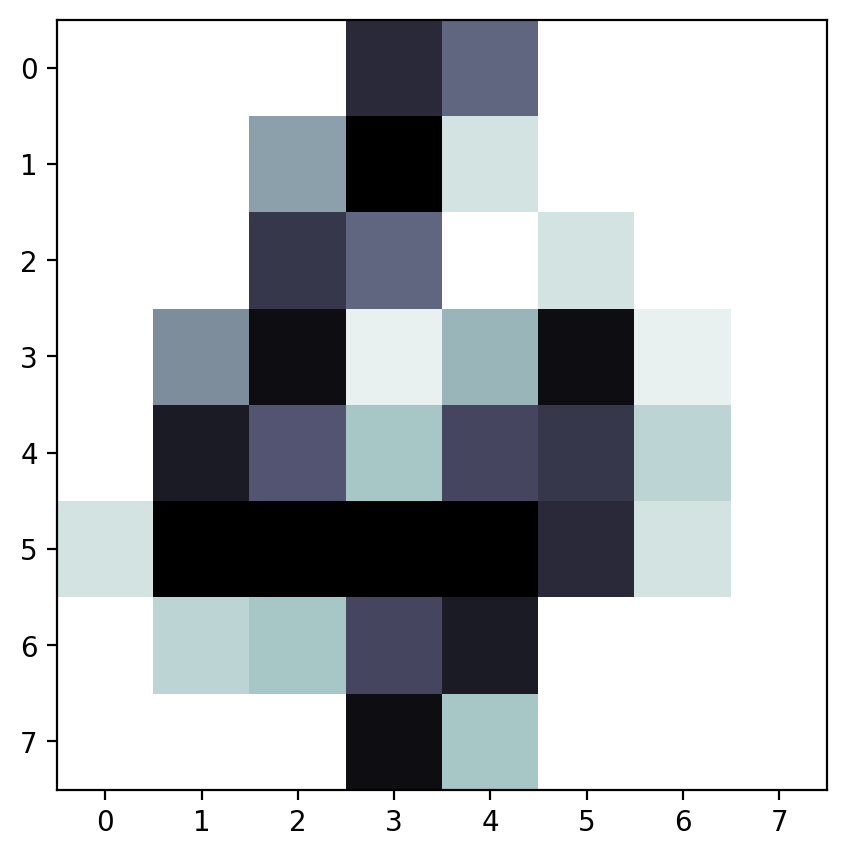

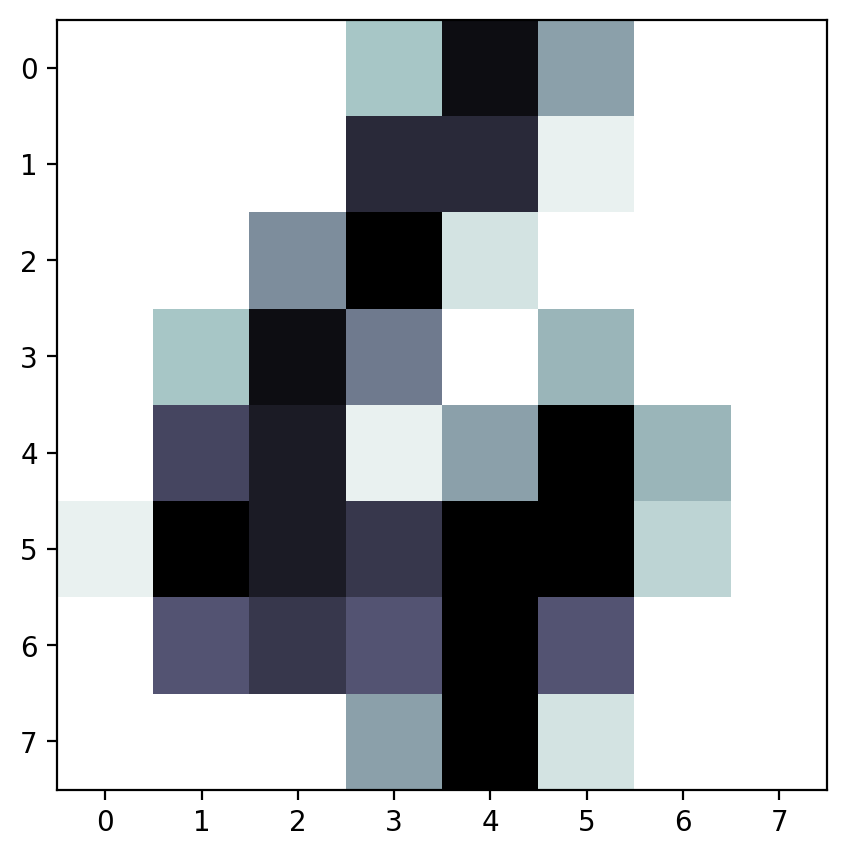

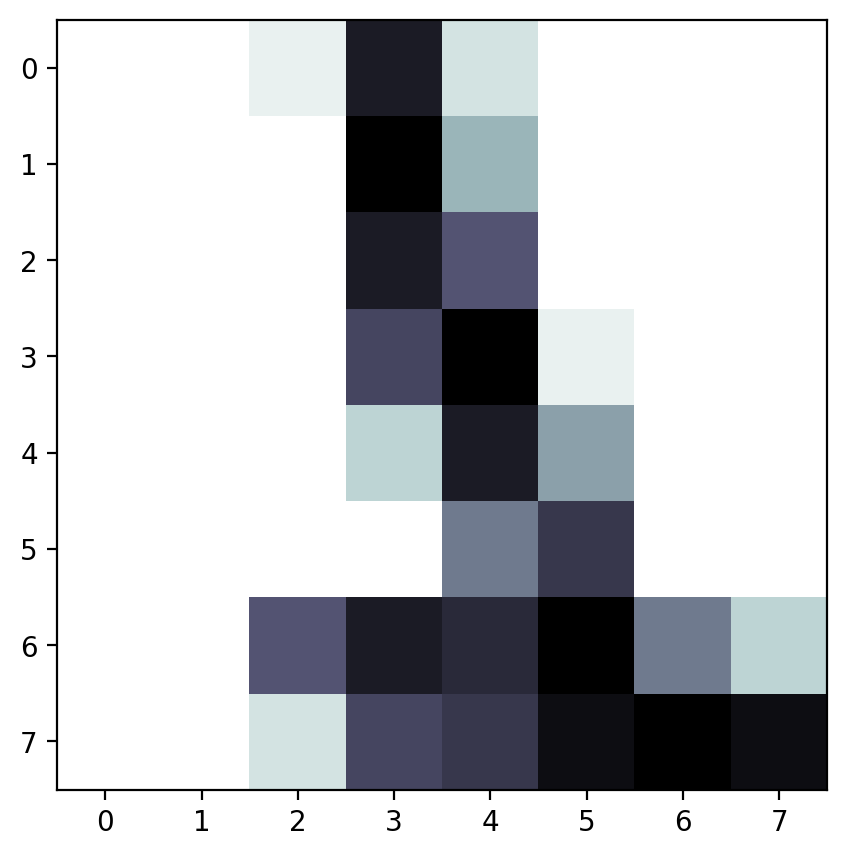

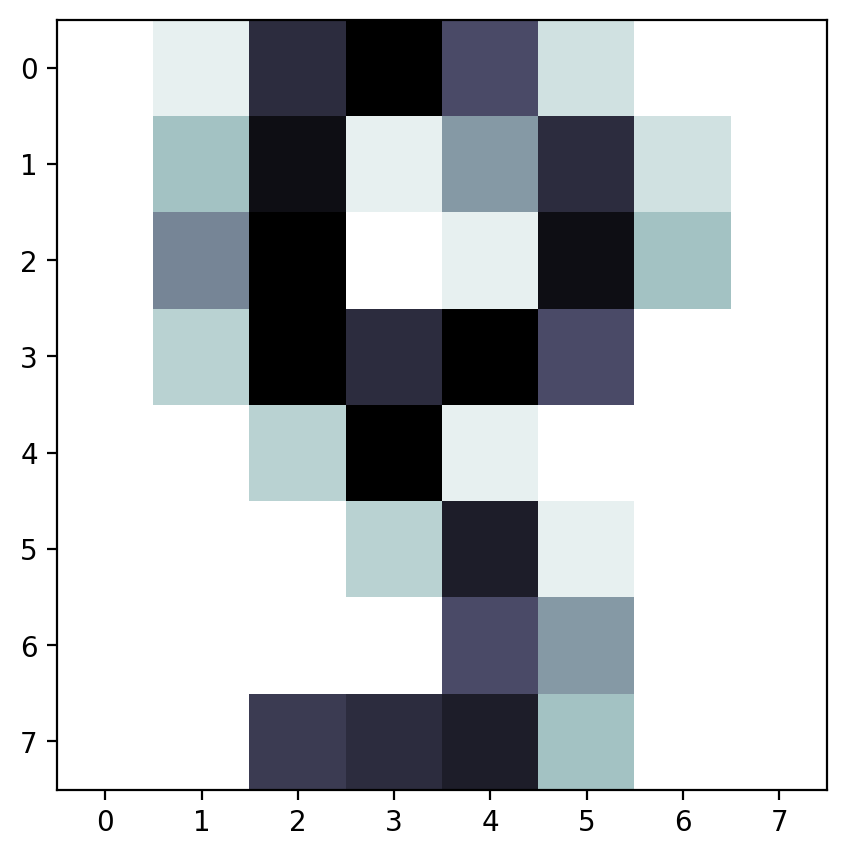

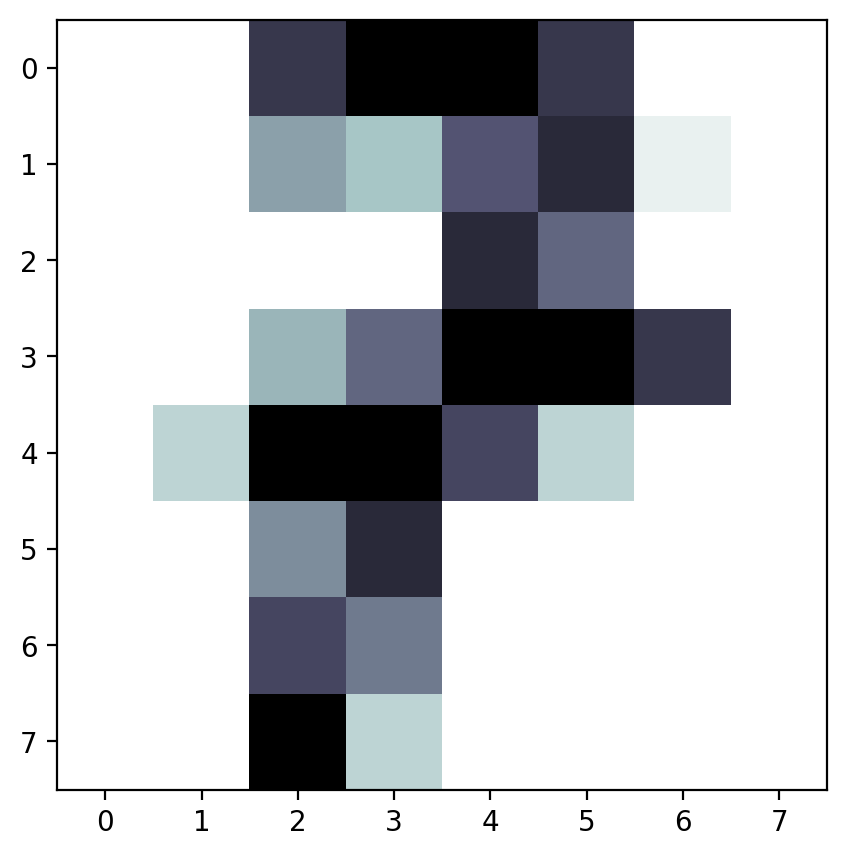

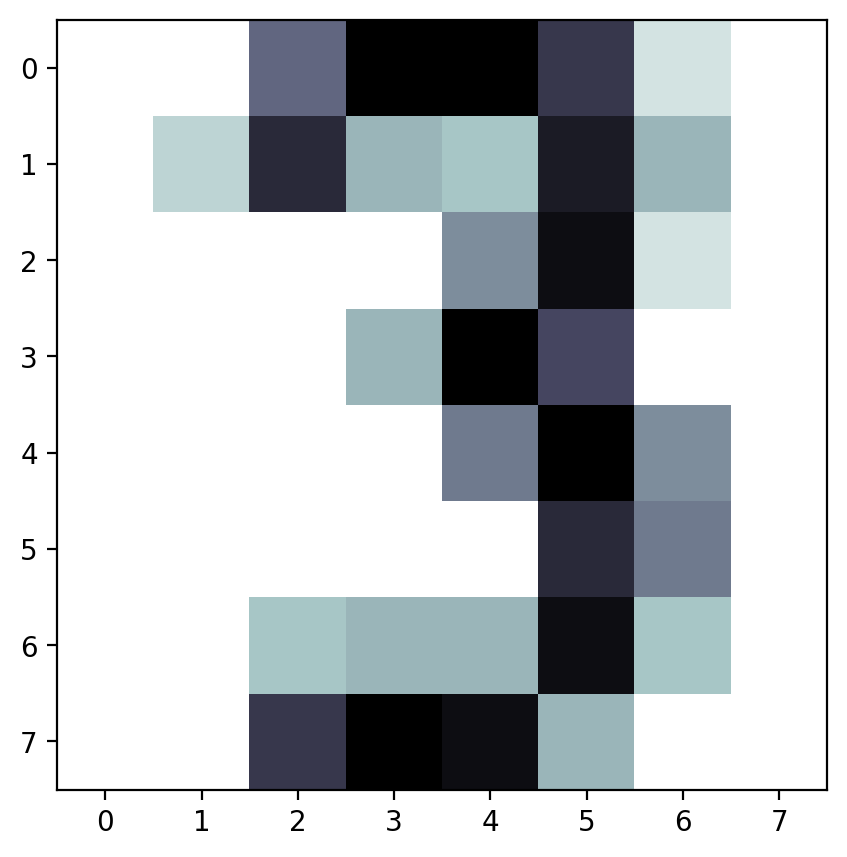

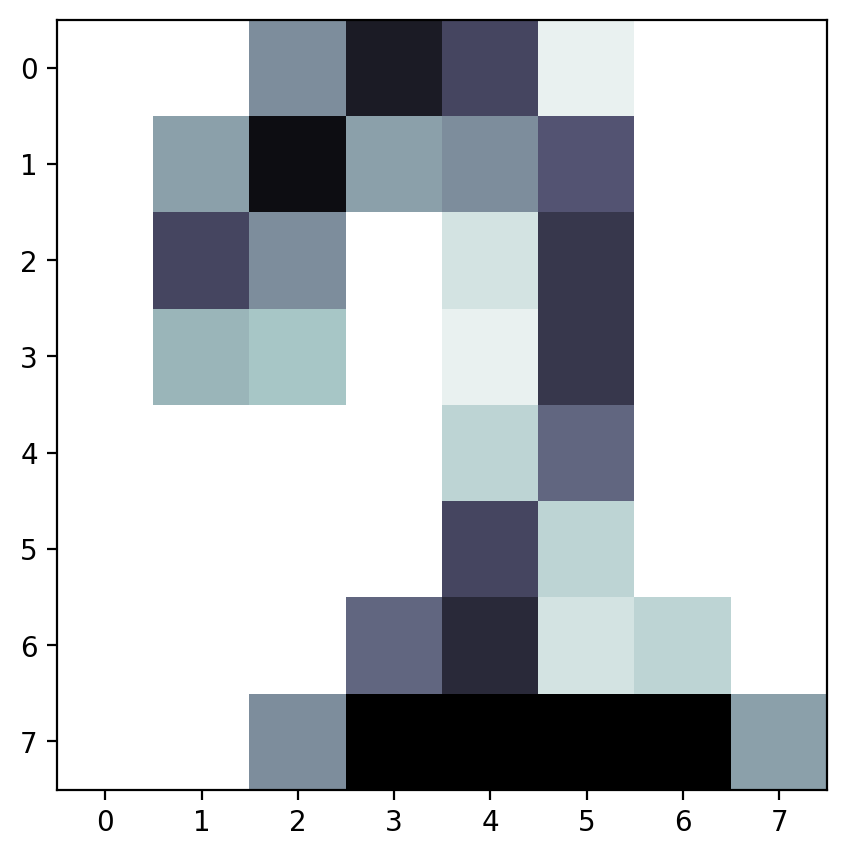

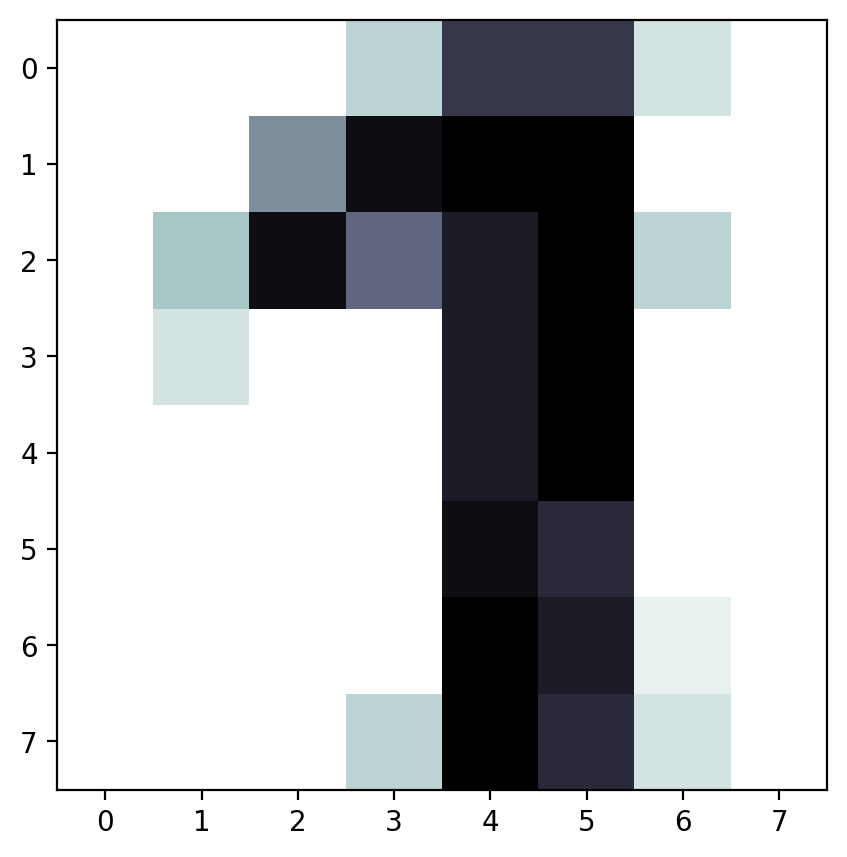

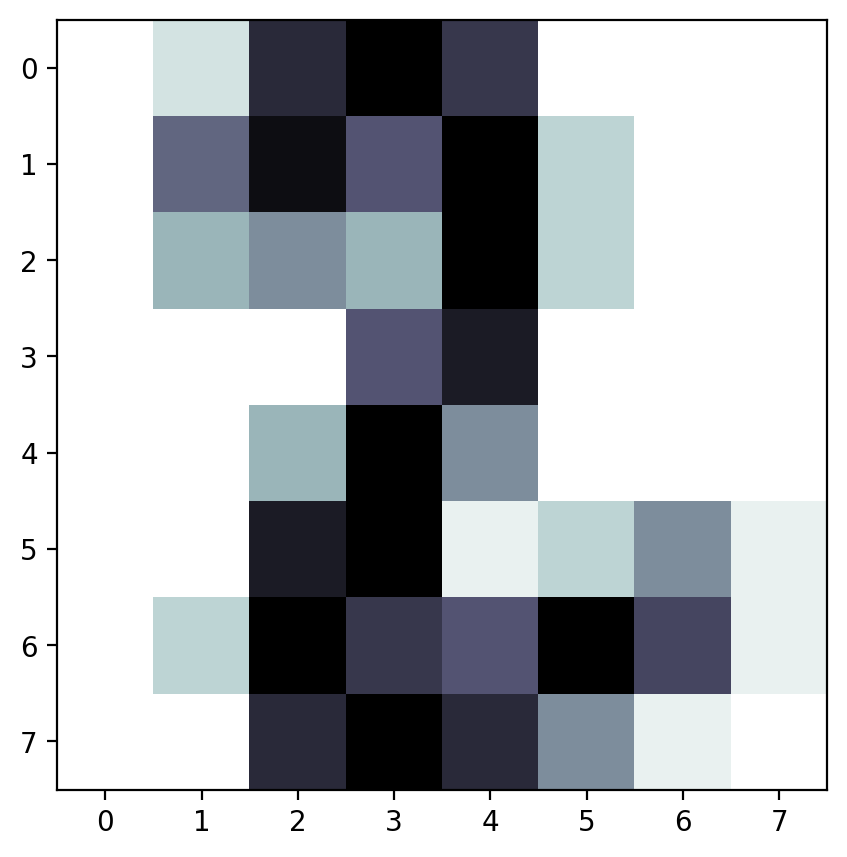

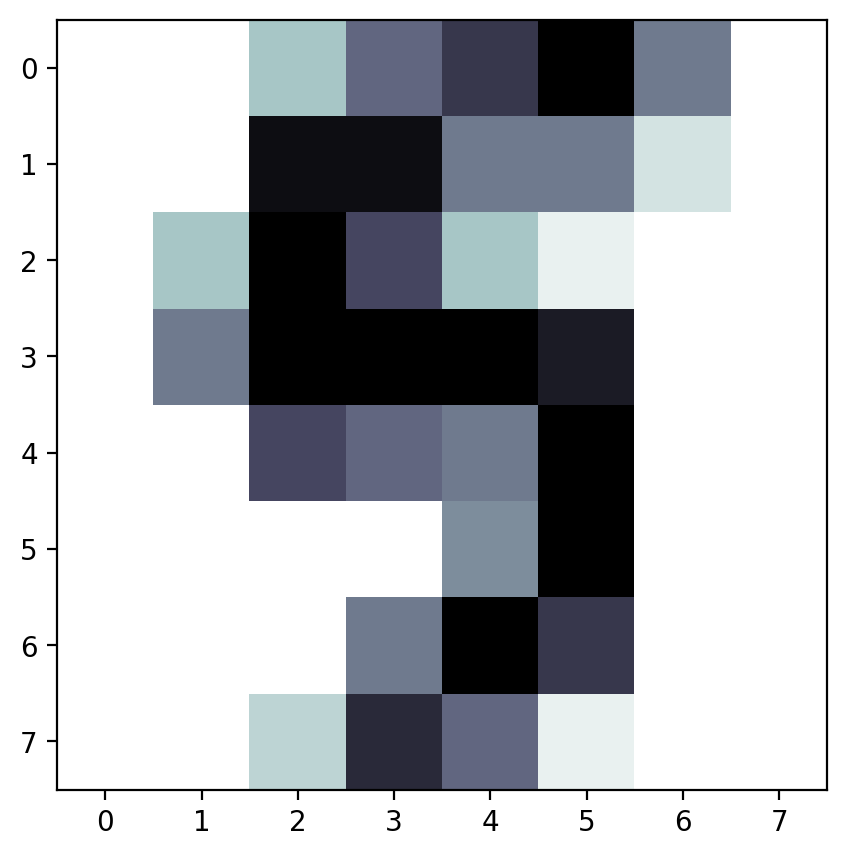

In [2]:
##Load the digits sample
from sklearn.datasets import load_digits

digits = load_digits()
for d in digits.data[::100]:
    grid_data = np.reshape(d, (8,8)) #reshape to 8x8
    plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
    plt.show()
X = digits.data
y = digits.target

Do the PCA transform, projecting to 2 dimensions and plot the results.

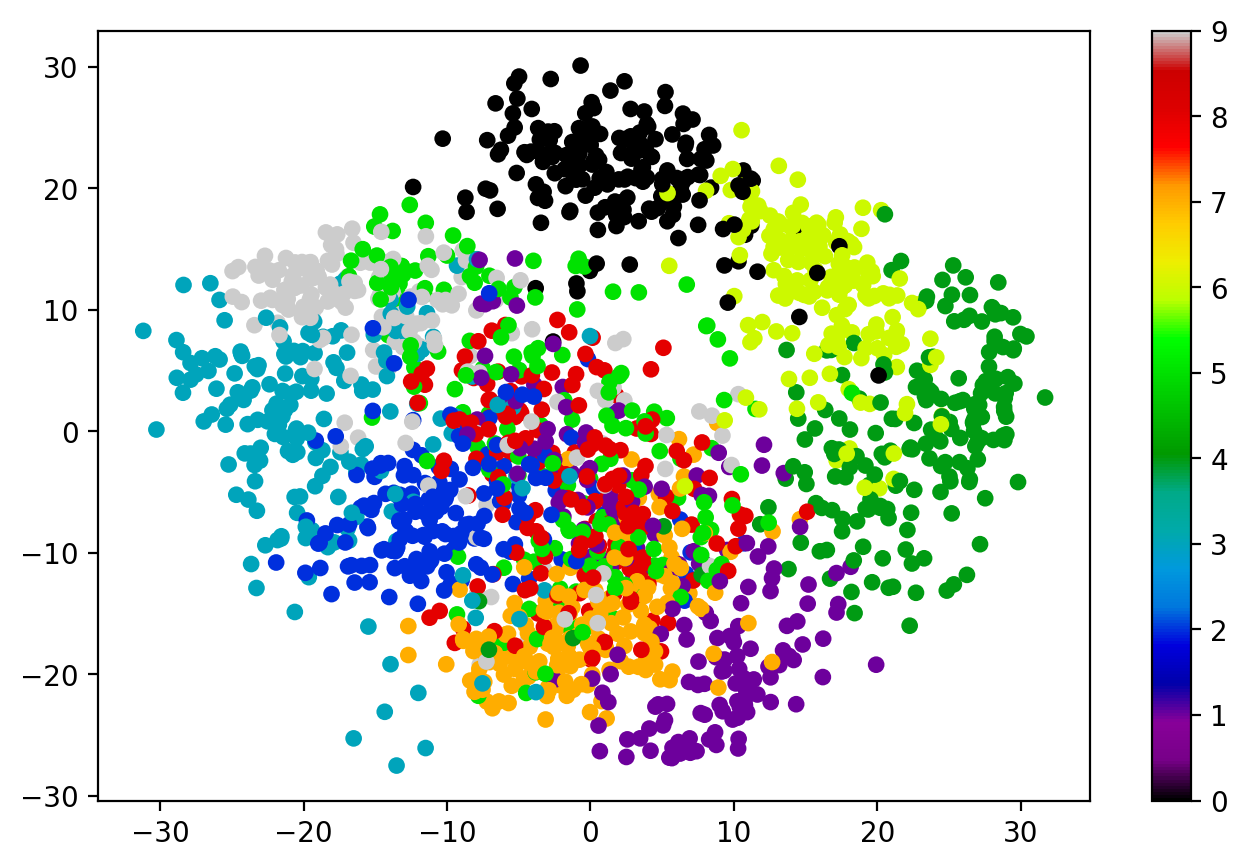

In [6]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

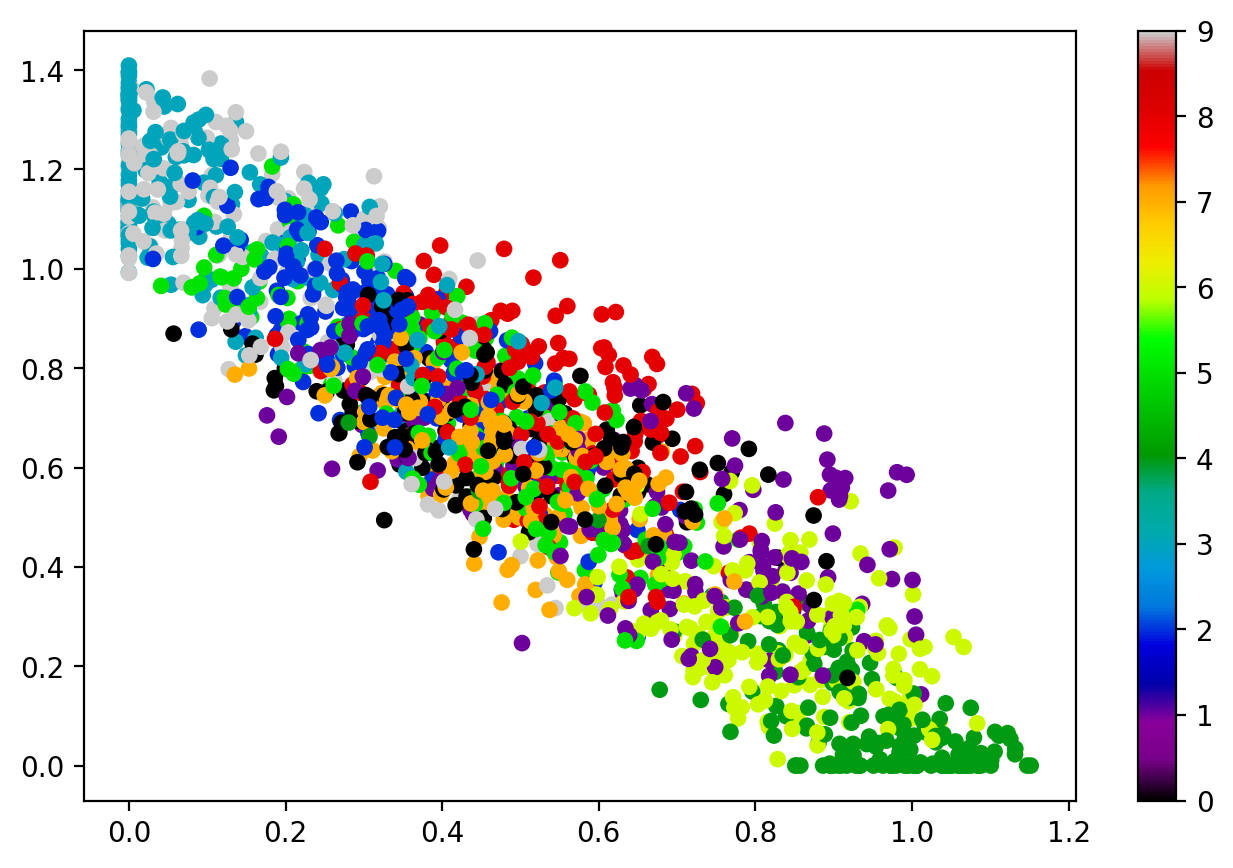

In [4]:
# NMF
from sklearn.decomposition import NMF
pca = NMF(n_components = 2)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

/home/nicolofiaba/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


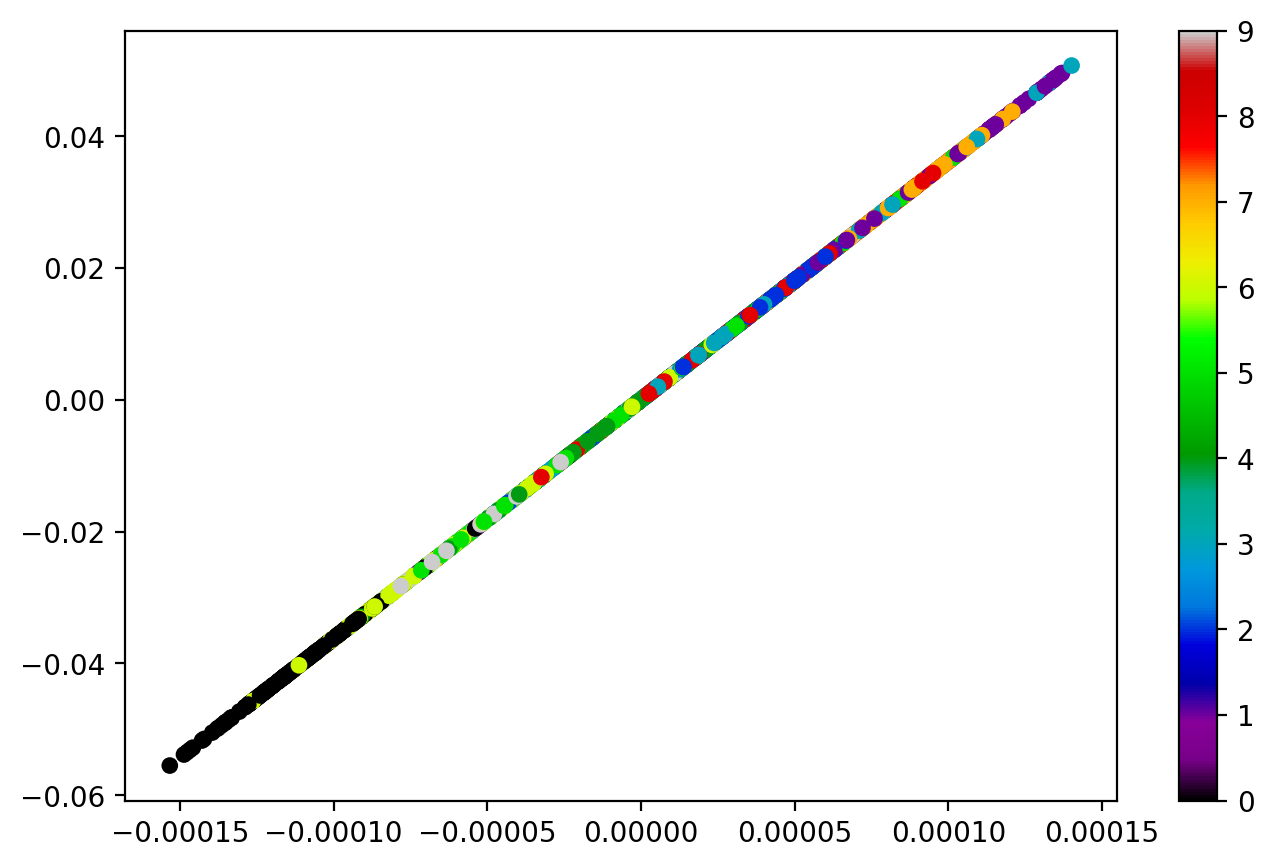

In [5]:
# ICA
from sklearn.decomposition import FastICA
pca = FastICA(n_components = 2)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

We could think about doing dimensional reduction of the digits data set in another way.  There are 64 pixels in each of our images. Presumably all of them aren't equally useful. Let's figure out exactly which pixels are the most relevant to determining the written number. We'll use Scikit-Learn's [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).  We won't get to regression until next week, for now just look at the inputs and outputs. Which pixels are the most important?

[52 36 20 21 28 29 27 42 35 62 33 34 26 18 12 30 63 51 60 43 13 61 10 19
 53 54 38 22 44 37 58  2  5 46 59 50 45  4 11 25 14  3 41  6 17  9  1 49
 57  7 55 15 16 23 24  8 40 31 47 48 32 39 56  0]


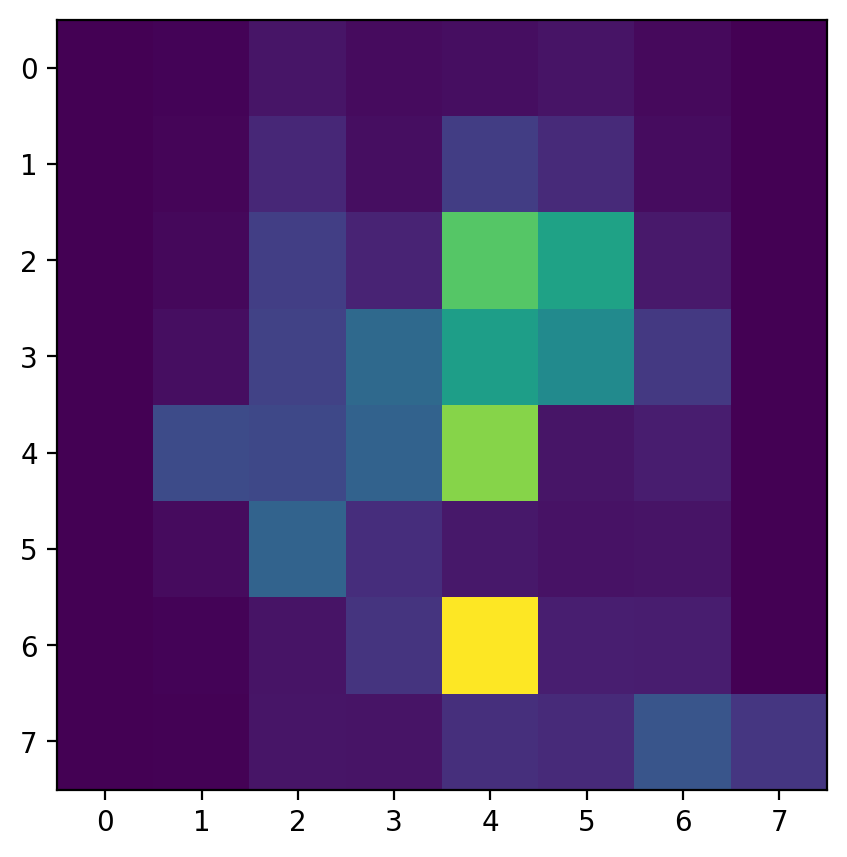

In [7]:
from sklearn.ensemble import RandomForestRegressor

RFreg = RandomForestRegressor() # Complete or leave blank as you see fit
RFreg.fit(X,y) # Do Fitting
importances = RFreg.feature_importances_# Determine pixel "importances"
pixelorder = np.argsort(importances)[::-1] # Rank importances (highest to lowest)
print(pixelorder) 

plt.figure()
plt.imshow(np.reshape(importances,(8,8)),
           interpolation="nearest")
plt.show()

Note that I'm using the target here! This is a supervised approach!



## Non-linear Dimensional Reduction <a class="anchor" id="one"></a>

PCA was nice, but linear. Often we don't have this luxury and the hidden relatioship between variables is intrisically non linear.


The concepts we need are: 
* manifold learning
* nonlinear dimensionality reduction

Specifically using the following algorithms
* locally linear embedding (LLE)
* isometric mapping (IsoMap)
* t-distributed Stochastic Neighbor Embedding (t-SNE)

A note of caution about the techniques you saw in the last lecture: PCA, NMF, and ICA are all linear methods. 

Astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but there is no physical reason for the data to be linearly and orthogonally separable. Moreover, physical components are (generally) positive definite. So, PCA is great for dimensional reduction, but for doing physics there are generally better choices.

While NMF "solves" the issue of negative components, it is still a linear process. For data with non-linear correlations, an entire field, known as [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html) and [nonlinear dimensionality reduction]( https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction), has been developed, with several algorithms available via the [`sklearn.manifold`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) module. 

For example, let's imagine your data set looks like this:

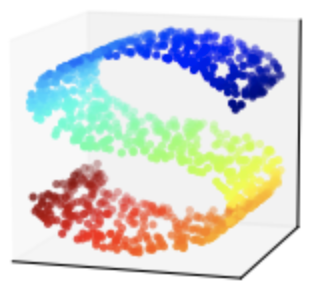

This is data drawn from an *S-shaped two-dimensional manifold embedded within three-dimensional space*. Seems easy to see. PCA is not going to know what to do with this because of the intrinsic non-linear structure. But let's give it a whirl; we get this:

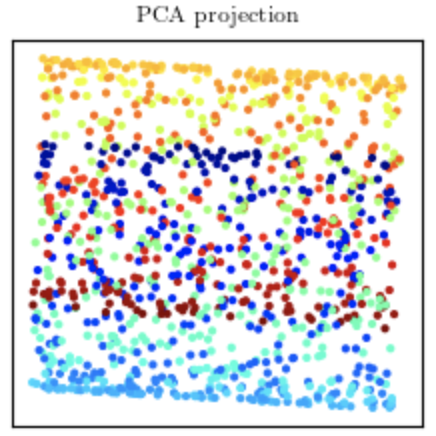

Clearly this is not helpful at all. There is no linear projection in which distant parts of the non-linear manifold do not overlap, resulting in the PCA projection mixing the colors.

***Manifold learning techniques*** on the other hand, do allow for this S-surface to be unwrapped so that its underlying structure is revealed. We'll look at some of these techniques today. Two techniques, **Locally linear embedding (LLE)** and **Isometric mapping (IsoMap)** show the power of these approaches:

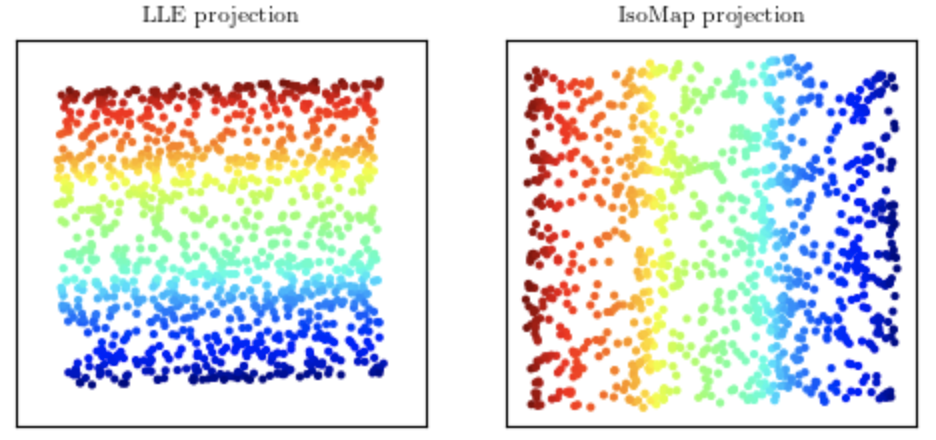

This is more like it! Here is how you would call these algorithms in sklearn:

/home/nicolofiaba/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


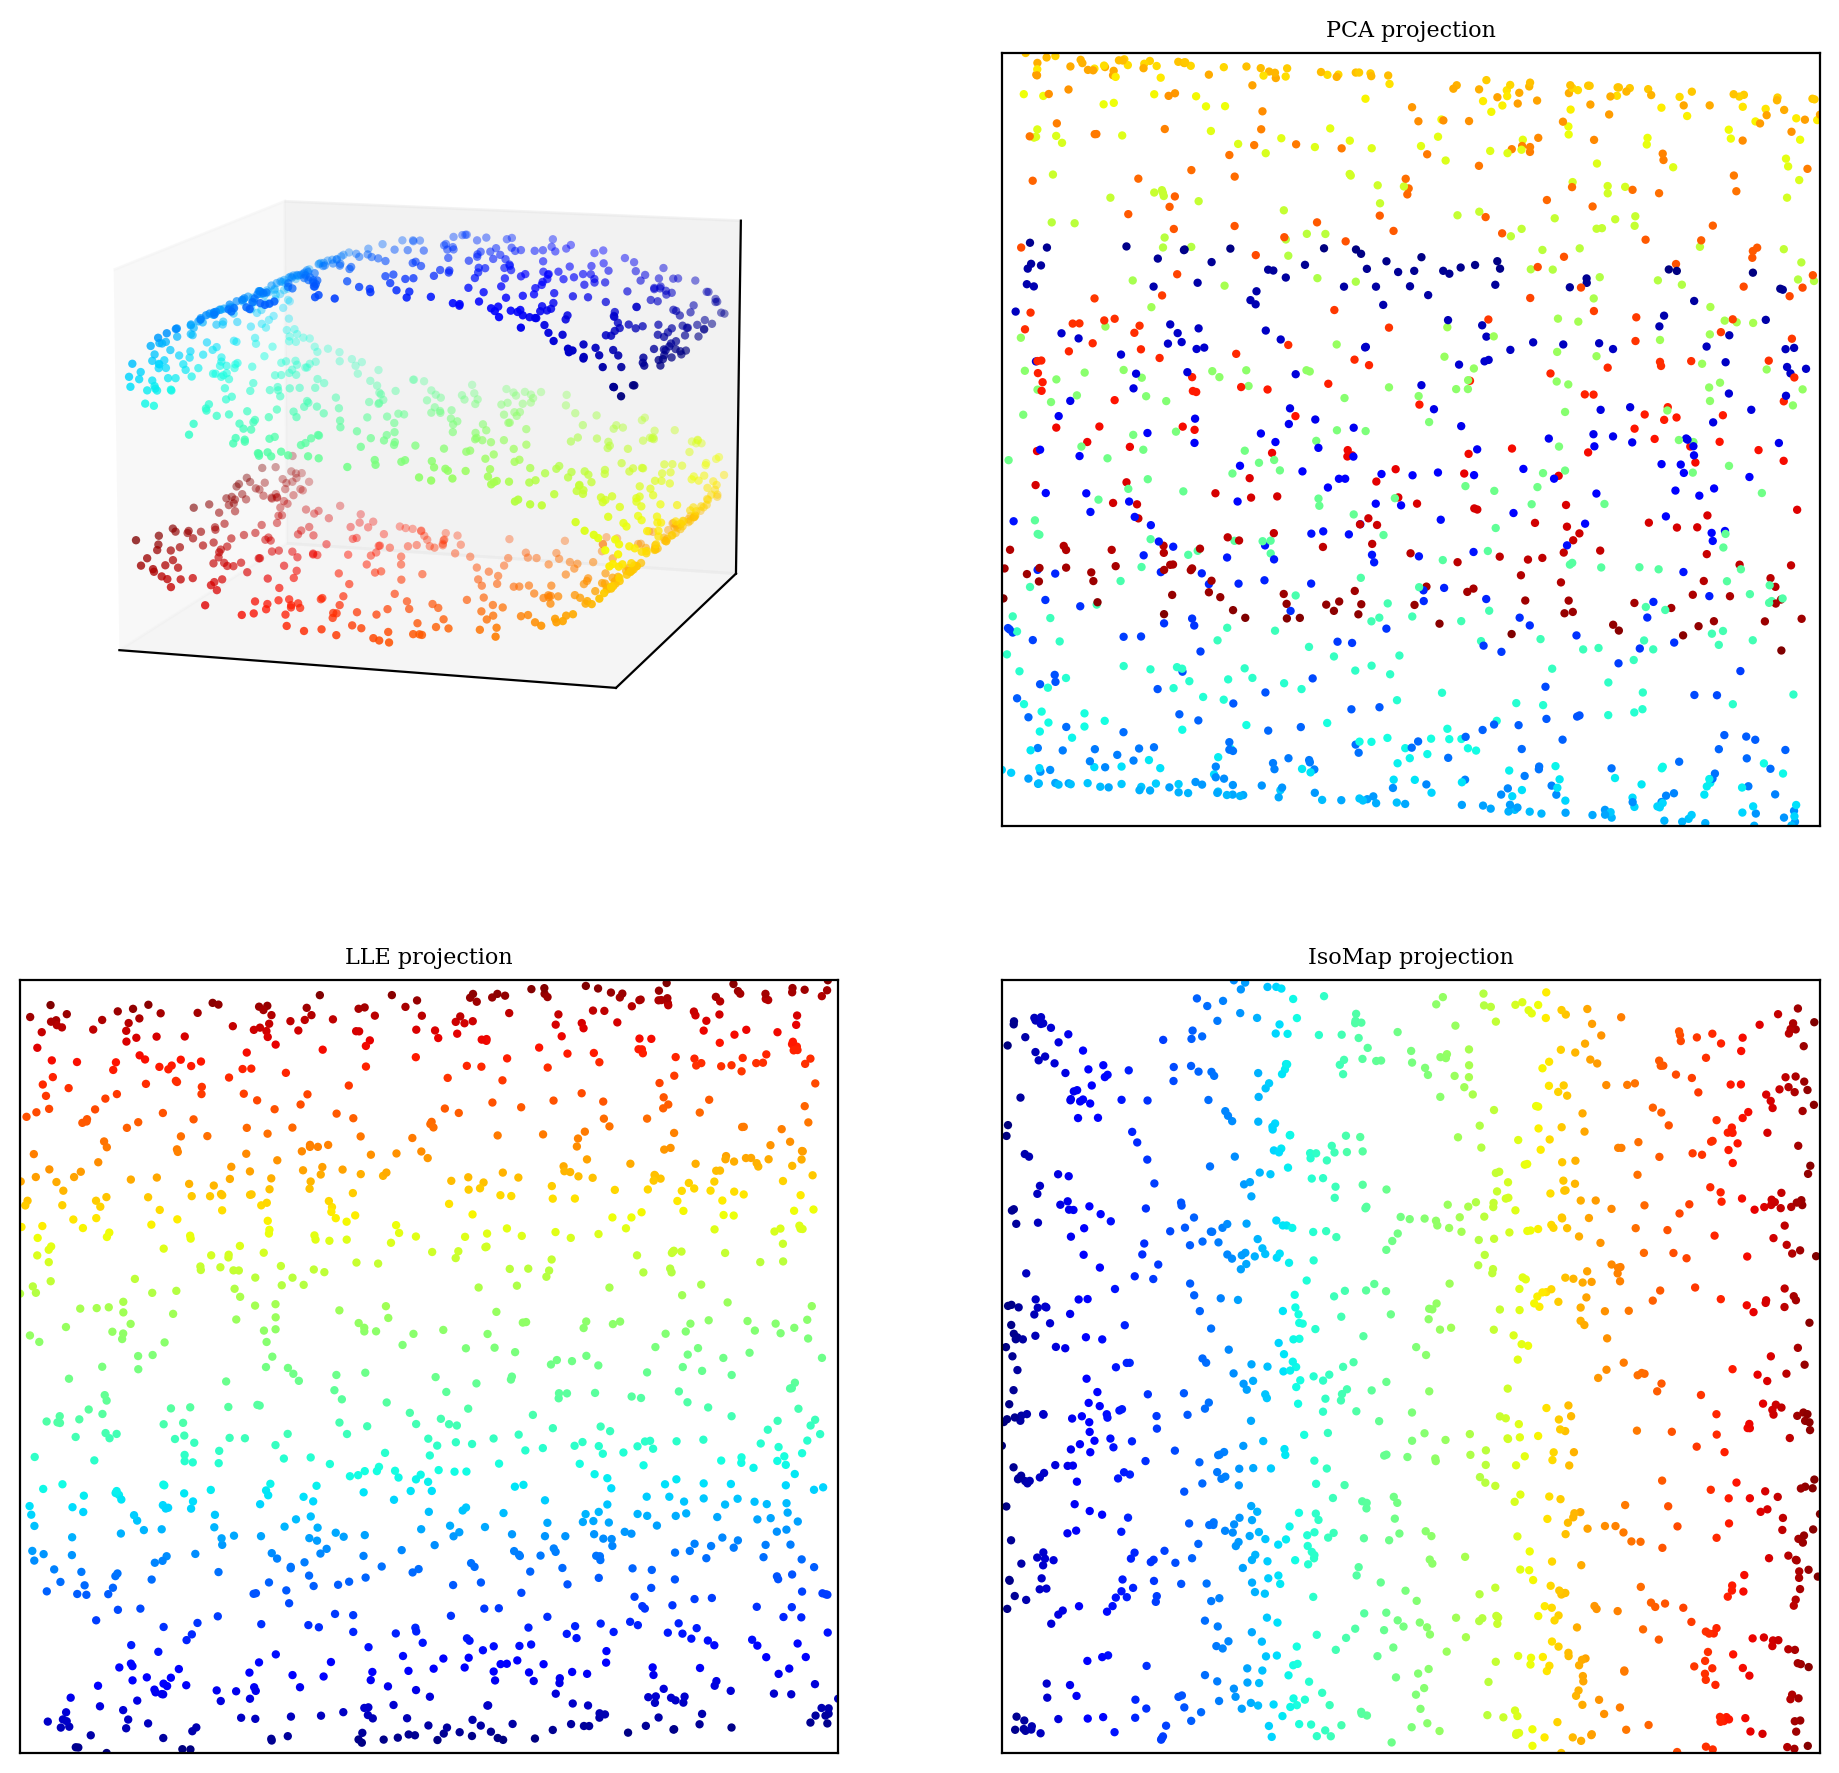

In [8]:
# Author: Jake VanderPlas
# Modified by SRT (2021)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import ticker
from sklearn import manifold, datasets, decomposition

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
n_neighbors = 10
out_dim = 2

X, color = datasets.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# Compute the projections
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)

lle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, 
                                      n_components=out_dim, 
                                      method='modified', random_state=0, 
                                      eigen_solver='dense')
Y_lle = lle.fit_transform(X)

iso = manifold.Isomap(n_neighbors=n_neighbors, 
                      n_components=out_dim)
Y_iso = iso.fit_transform(X)

#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)
try:
        # matplotlib 1.0+ has a toolkit for generating 3D plots
    from mpl_toolkits.mplot3d import Axes3D
    ax1 = fig.add_subplot(221, projection='3d',
                              xticks=[], yticks=[], zticks=[])
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                    cmap=plt.cm.jet, s=9, lw=0)
    ax1.view_init(11, -73)

except:
    # In older versions, we'll have to wing it with a 2D plot
    ax1 = fig.add_subplot(221)

    # Create a projection to mimic 3D scatter-plot
    X_proj = X / (X.max(0) - X.min(0))
    X_proj -= X_proj.mean(0)
    R = np.array([[0.5, 0.0],
                  [0.1, 0.1],
                  [0.0, 0.5]])
    R /= np.sqrt(np.sum(R ** 2, 0))
    X_proj = np.dot(X_proj, R)

    # change line width with depth
    lw = X[:, 1].copy()
    lw -= lw.min()
    lw /= lw.max()
    lw = 1 - lw

    ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=color,
                cmap=plt.cm.jet, s=9, lw=lw, zorder=10)

    # draw the shaded axes
    ax1.fill([-0.7, -0.3, -0.3, -0.7, -0.7],
             [-0.7, -0.3, 0.7, 0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.3, 0.7, 0.7, -0.3, -0.3],
             [-0.3, -0.3, 0.7, 0.7, -0.3], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.7, 0.3, 0.7, -0.3, -0.7],
             [-0.7, -0.7, -0.3, -0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)

    ax1.xaxis.set_major_locator(ticker.NullLocator())
    ax1.yaxis.set_major_locator(ticker.NullLocator())

#------------------------------------------------------------
# Plot the projections
subplots = [222, 223, 224]
titles = ['PCA projection', 'LLE projection', 'IsoMap projection']
Yvals = [Y_pca, Y_lle, Y_iso]

for (Y, title, subplot) in zip(Yvals, titles, subplots):
    ax = fig.add_subplot(subplot)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

For a nice examples in astronomy see
[Vanderplas & Connolly 2009](http://iopscience.iop.org/article/10.1088/0004-6256/138/5/1365/meta;jsessionid=48A569862A424ECCAEECE2A900D9837B.c3.iopscience.cld.iop.org), where they classify SDSS spectra using LLE:

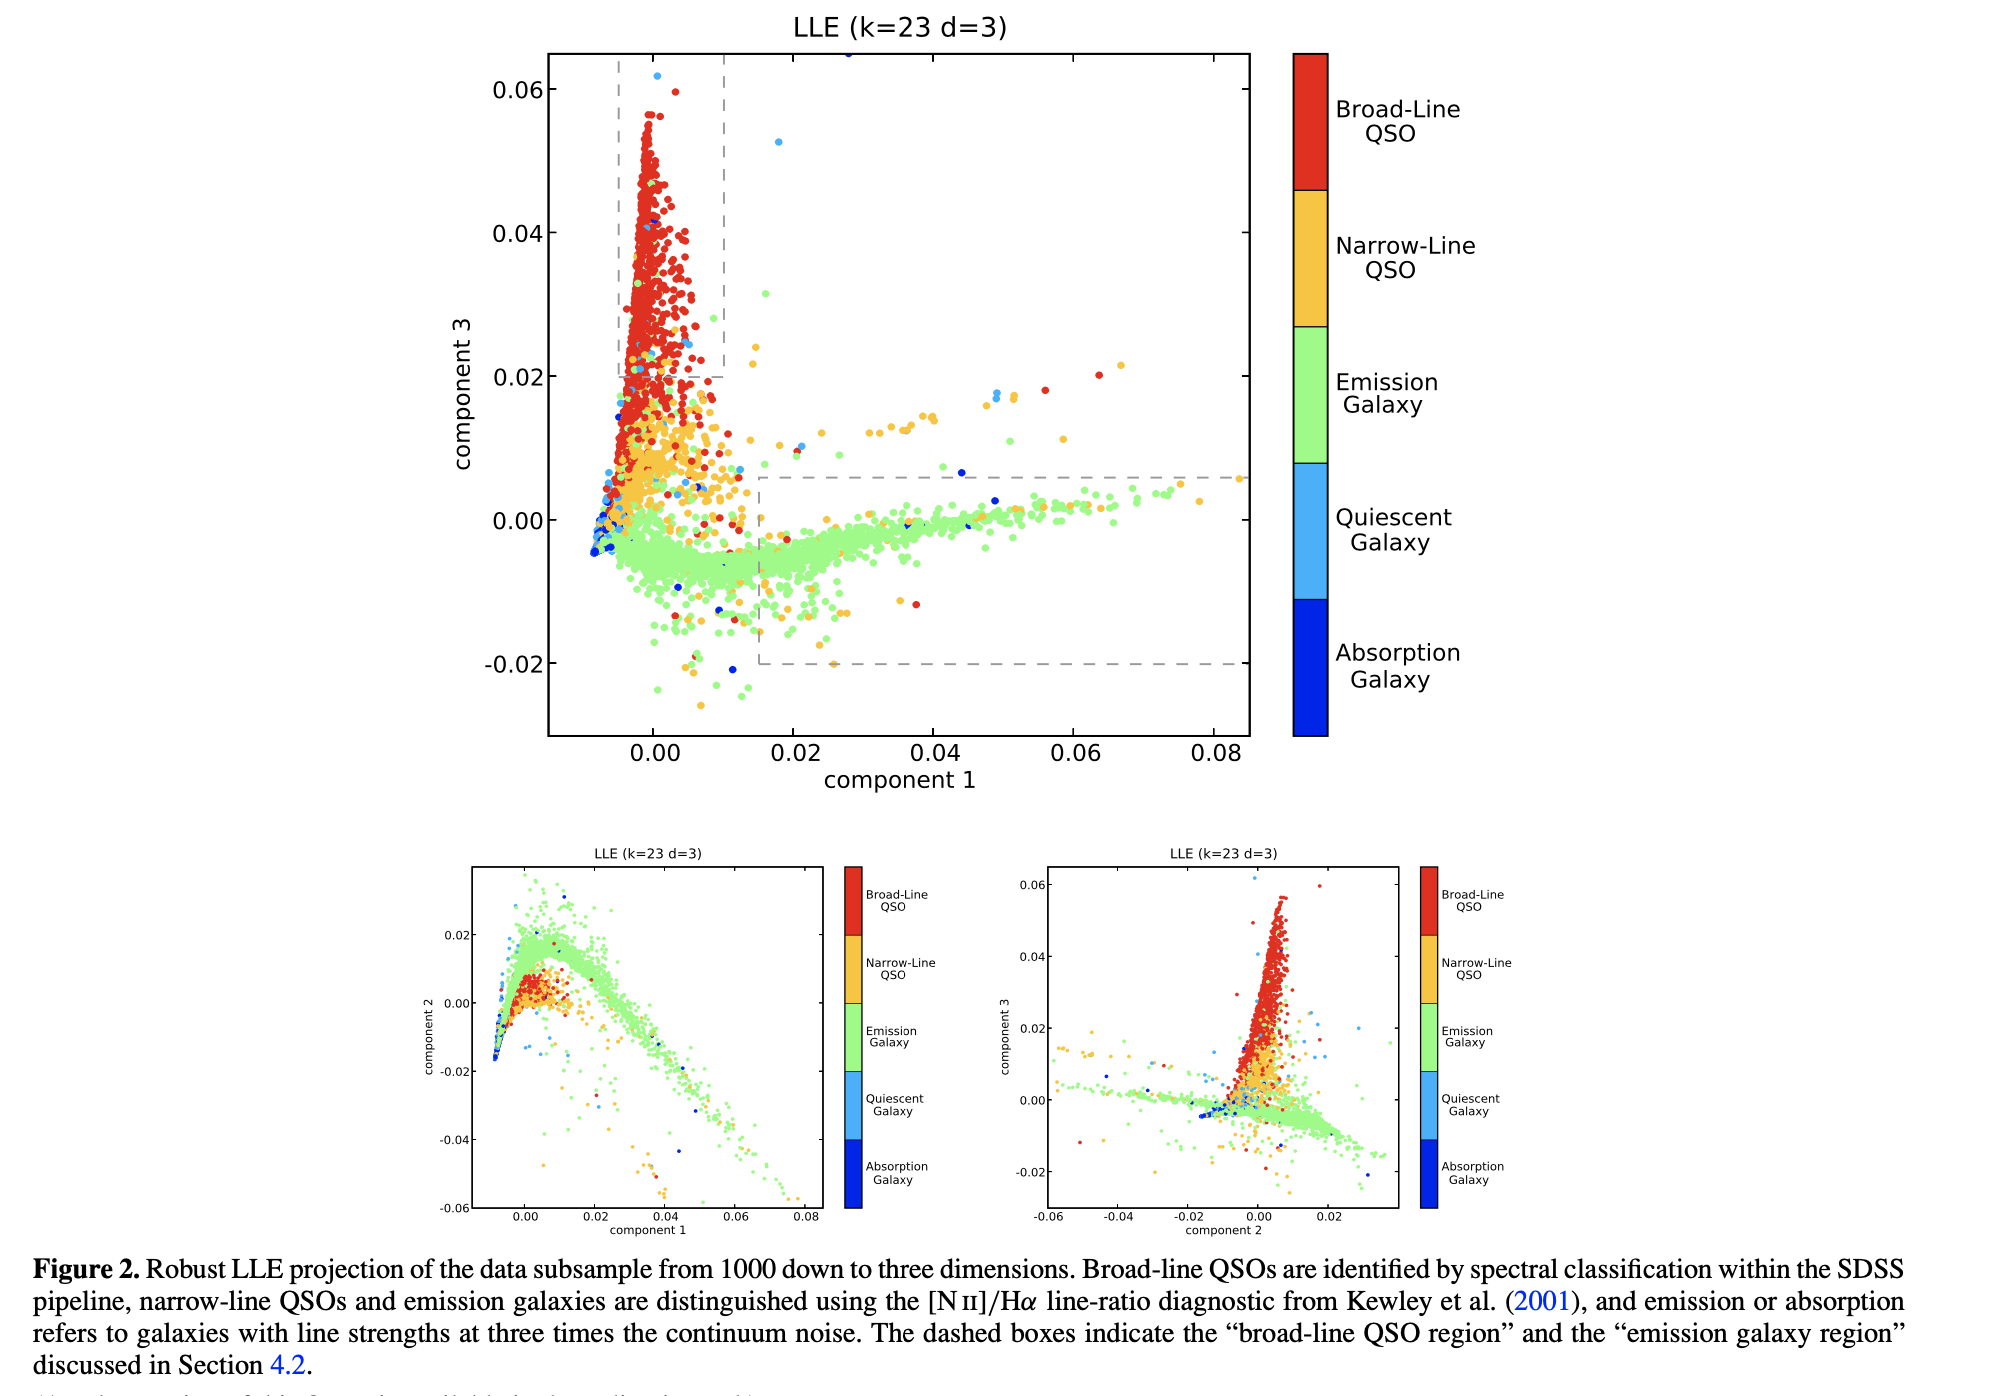


## Locally Linear Embedding (LLE) <a class="anchor" id="two"></a>

[Local Linear Embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) attempts to embed high-$D$ data in a lower-$D$ space.  Crucially it also seeks to preserve the geometry of the local "neighborhoods" around each point.  In the case of the "S" curve, it seeks to unroll the data.  The steps are

**STEP 1:** *define the local geometry*
- local neighborhoods are determined from each point's $k$ nearest neighbors.
- for each point calculate the weights that reconstruct a point from its $k$ nearest neighbors via
$$ \mathcal{E}_1(W) = \left|X - WX\right|^2,$$
where $X$ is an $N\times K$ matrix and $W$ is an $N\times N$ matrix that minimizes the reconstruction error.

Essentially this is **finding the hyperplane that describes the local surface at each point** within the data set. So, imagine that you have a bunch of square tiles and you are trying to tile the surface with them. 

One trivial solution of the above equation is $W=I$ where $I$ is an identity matrix-- however this can be avoided by constraining $W_{ii}=0$ for all points, $i$. The resulting constrained solution to $W$ is far more interesting, encoding the global geometry of the manifold through each point's relation to all others. 

- take the constrained solution a step further by setting all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$. 

Each row of $W$ encodes the local geometry of each point, and the matrix as a whole encodes the global geometry of the manifold.

**STEP 2:** *embed within a lower dimensional space* 
- $W$ becomes very sparse for $k \ll N$ (only $Nk$ entries in $W$ are non-zero). 
- minimize
$$ \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,$$
with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality).

This final step corresponds to finding a lower dimensional embedding of the data, $Y$, that reflects the geometry of the local neighborhoods in the original data matrix, $X$.

***Step 1 requires a nearest-neighbor search. Step 2 requires an eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$.*** 

LLE has been applied to data as diverse as galaxy spectra, stellar spectra, and photometric light curves. It was introduced by [Roweis & Saul (2000)](https://www.ncbi.nlm.nih.gov/pubmed/11125150). Roweis has some fun examples on his website, including an LLE of a twin peaked surface, reduced down to a lower dimension:

![](https://cs.nyu.edu/~roweis/lle/images/twinPeaks.gif)

An even more interesting example is an LLE analysis of face images. By unwrapping many images into vectors of pixels and stacking to form a data matrix, LLE can be used to discriminate facial expressions:

![](https://cs.nyu.edu/~roweis/lle/images/faceex1.gif)

Scikit-learn's call to LLE is as follows, with a more detailed example already being given above.

In [9]:
from sklearn.manifold import LocallyLinearEmbedding

X = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
X = np.dot(X,R) # now a 2D linear manifold in 10D space

k = 5 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

lle = LocallyLinearEmbedding(n_neighbors=k, 
                             n_components=n)
lle.fit(X)
proj = lle.transform(X) # 1000x2 projection of the data

Let's see what LLE does for the digits data, using the 7 nearest neighbors and 2 components.

In [10]:
# Execute this cell to load the digits sample
from sklearn.datasets import load_digits

digits = load_digits()
grid_data = np.reshape(digits.data[0], (8,8)) #reshape to 8x8
#plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
#print(grid_data)
X = digits.data
y = digits.target

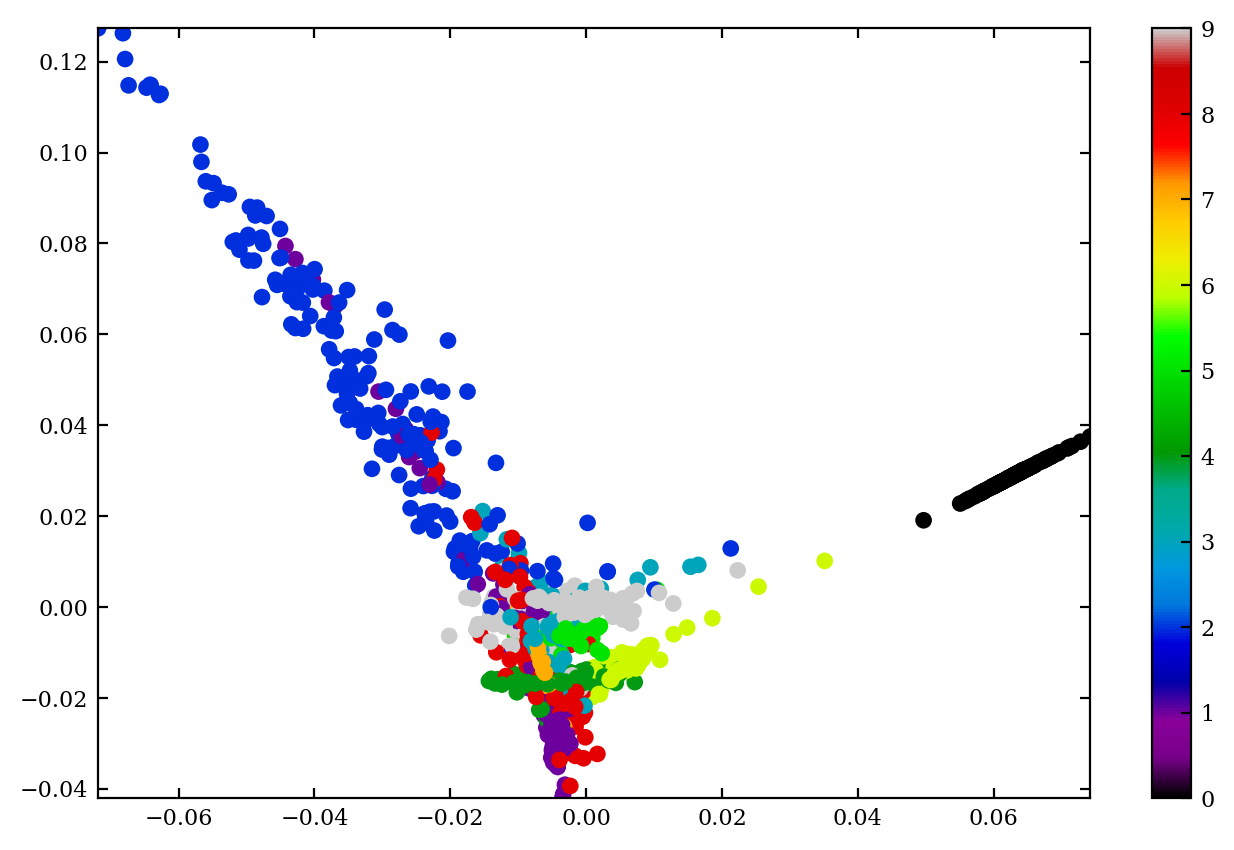

In [11]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding
k = 17 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit
lle = LocallyLinearEmbedding(n_neighbors=k,
                             n_components=n)
lle.fit(X)
X_reduced = lle.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

## Isometric Mapping (IsoMap) <a class="anchor" id="three"></a>

**IsoMap** is based on the multi-dimensional scaling (MDS) framework. Classical MDS recovers a data set from the matrix of pairwise distances between points. 

IsoMap was coincidentally introduced in the same volume of *Science* as the LLE article above. See [Tenenbaum, de Silva, & Langford (2000)](https://www.ncbi.nlm.nih.gov/pubmed/?term=A+Global+Geometric+Framework+for+Nonlinear+Dimensionality+Reduction).

***IsoMap seeks to find a lower dimensional embedding of the data marix that maintains the geodesic distances between all points.*** Rather than using Euclidean distances between points, IsoMap actually approximates geodesic curves that lie in the embedded manifold, then **computes the distances between each point in the data set along these geodesics**. This can be seen in the image below from Tenenbaum et al.-- the dataset is a ["Swiss Roll"](https://www.wikiwand.com/en/Swiss_roll). 

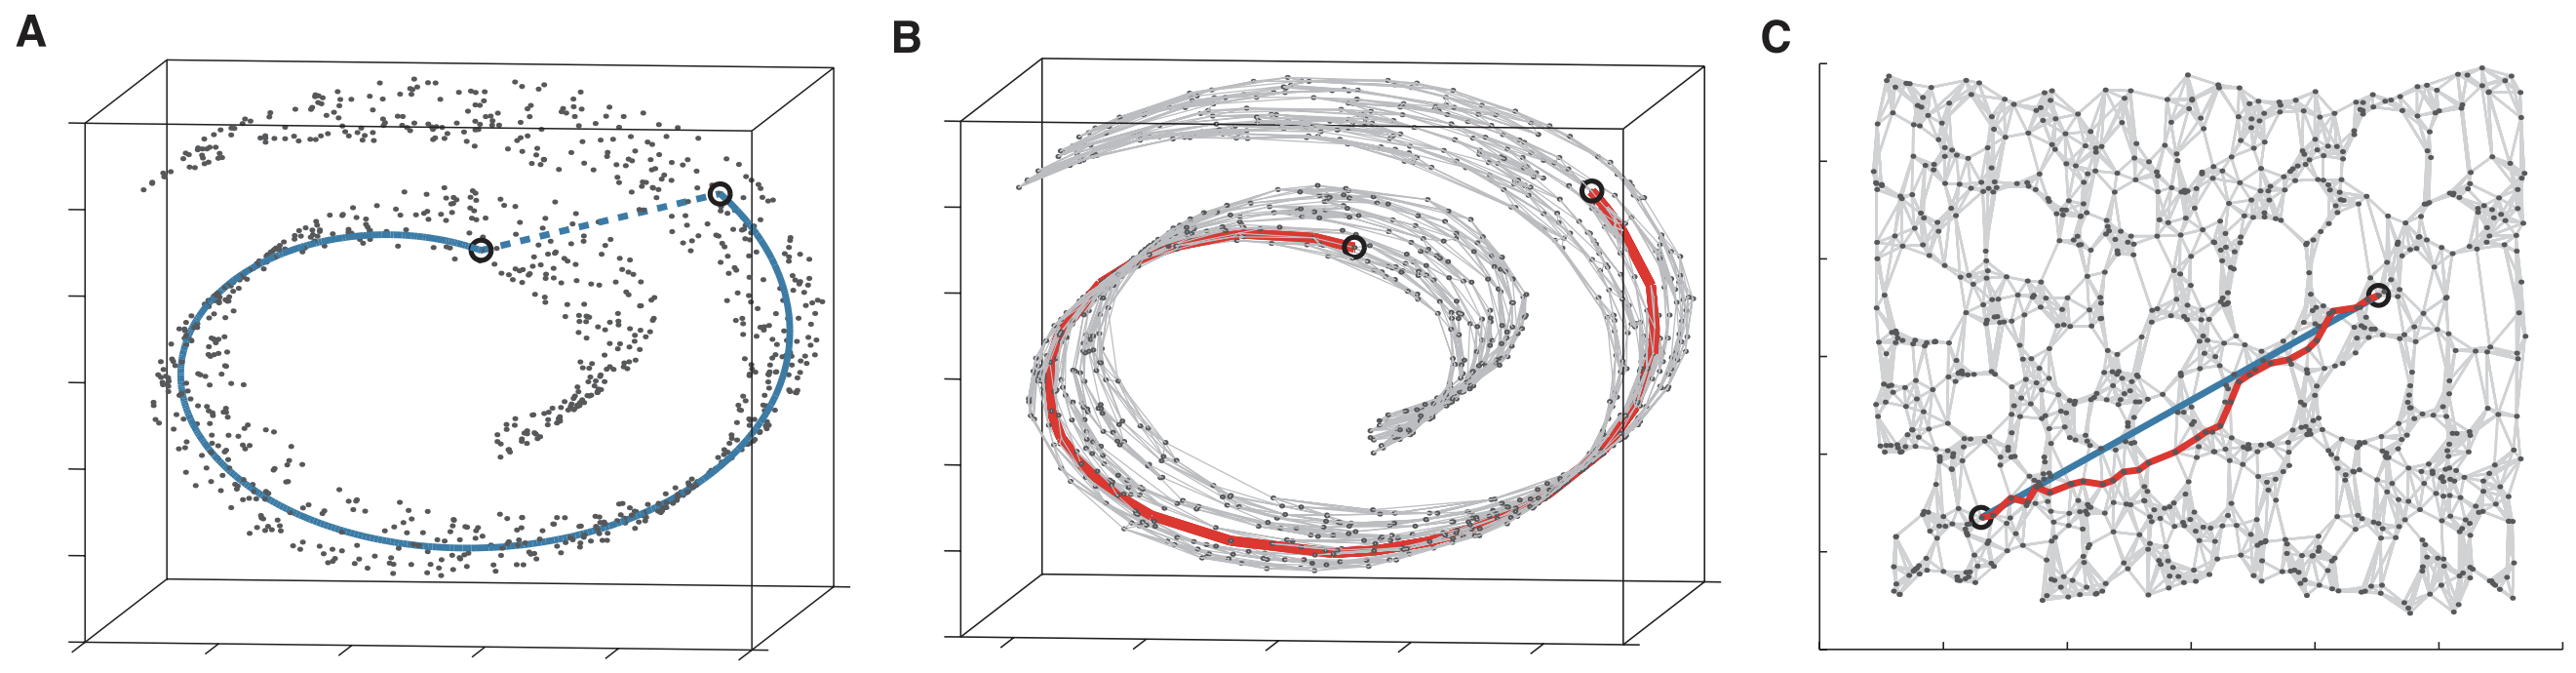


- In the **left panel**, one can see that the Euclidean distance between two points (dashed line) is not a true reflection of how far apart they are on the embedded manifold (solid line). 
- In the **middle panel**, a [neighboorhood graph](https://www.wikiwand.com/en/Neighbourhood_(graph_theory)) is constructed that connects each point to its neighboors, allowing the geodesic distance between points to be computed by finding the shortest path through the graph.
- In the **right panel**, a lower dimensional embedding of the manifold is recovered by IsoMap that preserves the relative geodesic distances between points.

For the final step of finding the optimal low-dimensional embedding, MDS algorithm technqiues are used to minimize the reconstruction error:

$$ \mathcal{E}_{XY} = |\tau(D_X) - \tau(D_Y)|^2 $$

between the original data set $X$ and the low-dimensional embedding $Y$, where $\tau$ is some operator on the distance matrices.

In Scikit-Learn [IsoMap](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) is implemented as follows:

In [12]:
# Execute this cell
from sklearn.manifold import Isomap

XX = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
XX = np.dot(XX,R) # X is a 2D manifold in 10D space

k = 5 # number of neighbors
n = 2 # number of dimensions

iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(XX)
proj = iso.transform(XX) # 1000x2 projection of the data

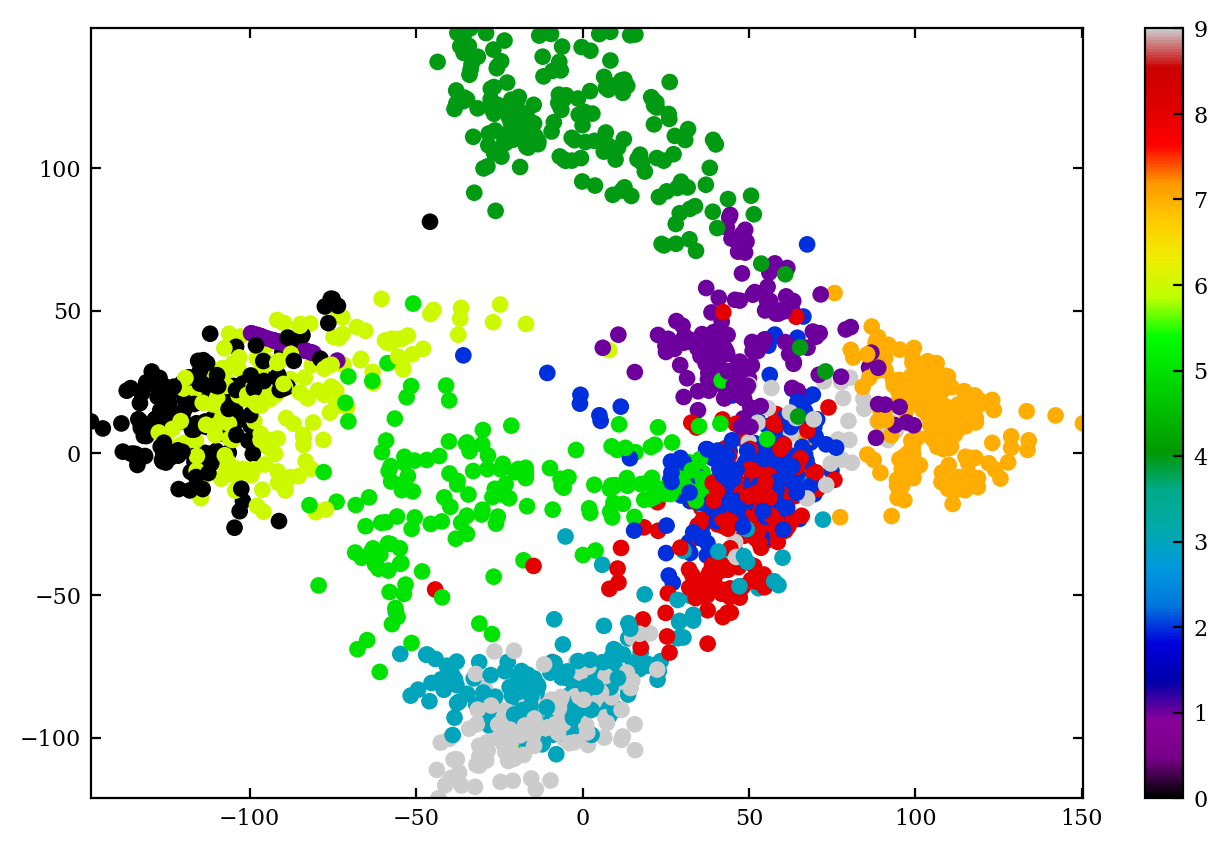

In [13]:
# IsoMap
k = 7 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

iso = Isomap(n_neighbors=k,
             n_components=n)
iso.fit(X)

X_reduced = iso.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

## t-distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="four"></a>

**[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)** is not discussed in the book, but Scikit-Learn does have a [t-SNE implementation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), and it is well worth mentioning this powerful manifold learning algorithm too. 

SNE itself was developed by [Hinton & Roweis](http://www.cs.toronto.edu/~fritz/absps/sne.pdf) with the "$t$" part being added by [van der Maaten & Hinton](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). It works like the other manifold learning algorithms. To give you an idea of how cutting edge this is compared to other techniques we've seen, t-SNE was only published in $2008$. PCA dates from $1933$; alot has changed in computational physics since then.

> [t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance.](https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f)


For an astronomy example on stellar chemical abundances [Anders et al 2019](https://arxiv.org/abs/1803.09341). 

A high-level description of the steps in t-SNE are as follows:

**STEP 1**: *measure the similarity between points in the original high-dimensional space*
- this is done by centering a multivariate Gaussian on each point and measuring the pdf value of all neighboors.
- the bandwidth of the Gaussian can be chosen to tweak something called the *perplexity*, which essentially relates to the number of nearest neighboors being considered.
- the result is a matrix of probabilities of each point under a Gaussian centered under every other point, $p_{ij}$.
- this "similarity matrix" is a measure of local structure.

**STEP 2**: *find a lower-dimensional mapping that preserves the similarities, $p_{ij}$*
- a heavy-tailed Student's $t$-distribution with $1$-degree of freedom (i.e. a Cauchy distribution) is used to model the probabilities between pairs of points in the low-dimensional embedding, $q_{ij}$.
- this allows dissimilar objects to be modeled as being far apart on the map. 
- A quantity known as the [Kullback-Leibler divergence](https://www.wikiwand.com/en/Kullback%E2%80%93Leibler_divergence) is used to minimize differences between $p_{ij}$ and $q_{ij}$. 

Try it on the digits data. You'll need to import `TSNE` from `sklearn.manifold`, instantiate it with 2 components, then do a `fit_transform` on the original data.

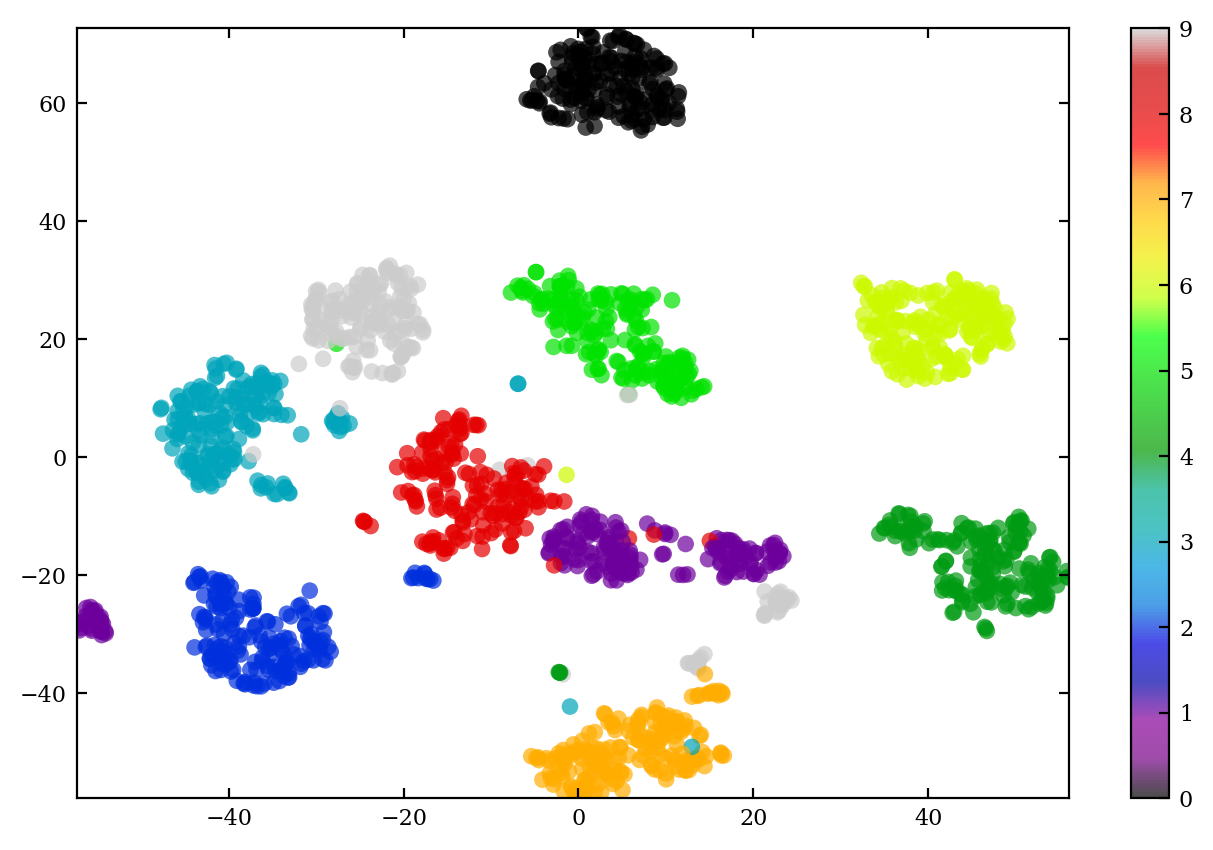

In [17]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate=200)
X_reduced = tsne.fit_transform(X)

plt.scatter(X_reduced[:,0],X_reduced[:,1], 
            c=y, cmap="nipy_spectral", alpha=0.7, 
            edgecolor="None")
plt.colorbar()

I mean... Wow! Imagine now running a clustering there (**homework, try!**). It's going to find every single blob very easily.

What's even more illuminating is to make the plot using the actual digits to plot the points.  Then you can see why certain digits are alike or split into multiple regions.  Can you explain the patterns you see here?

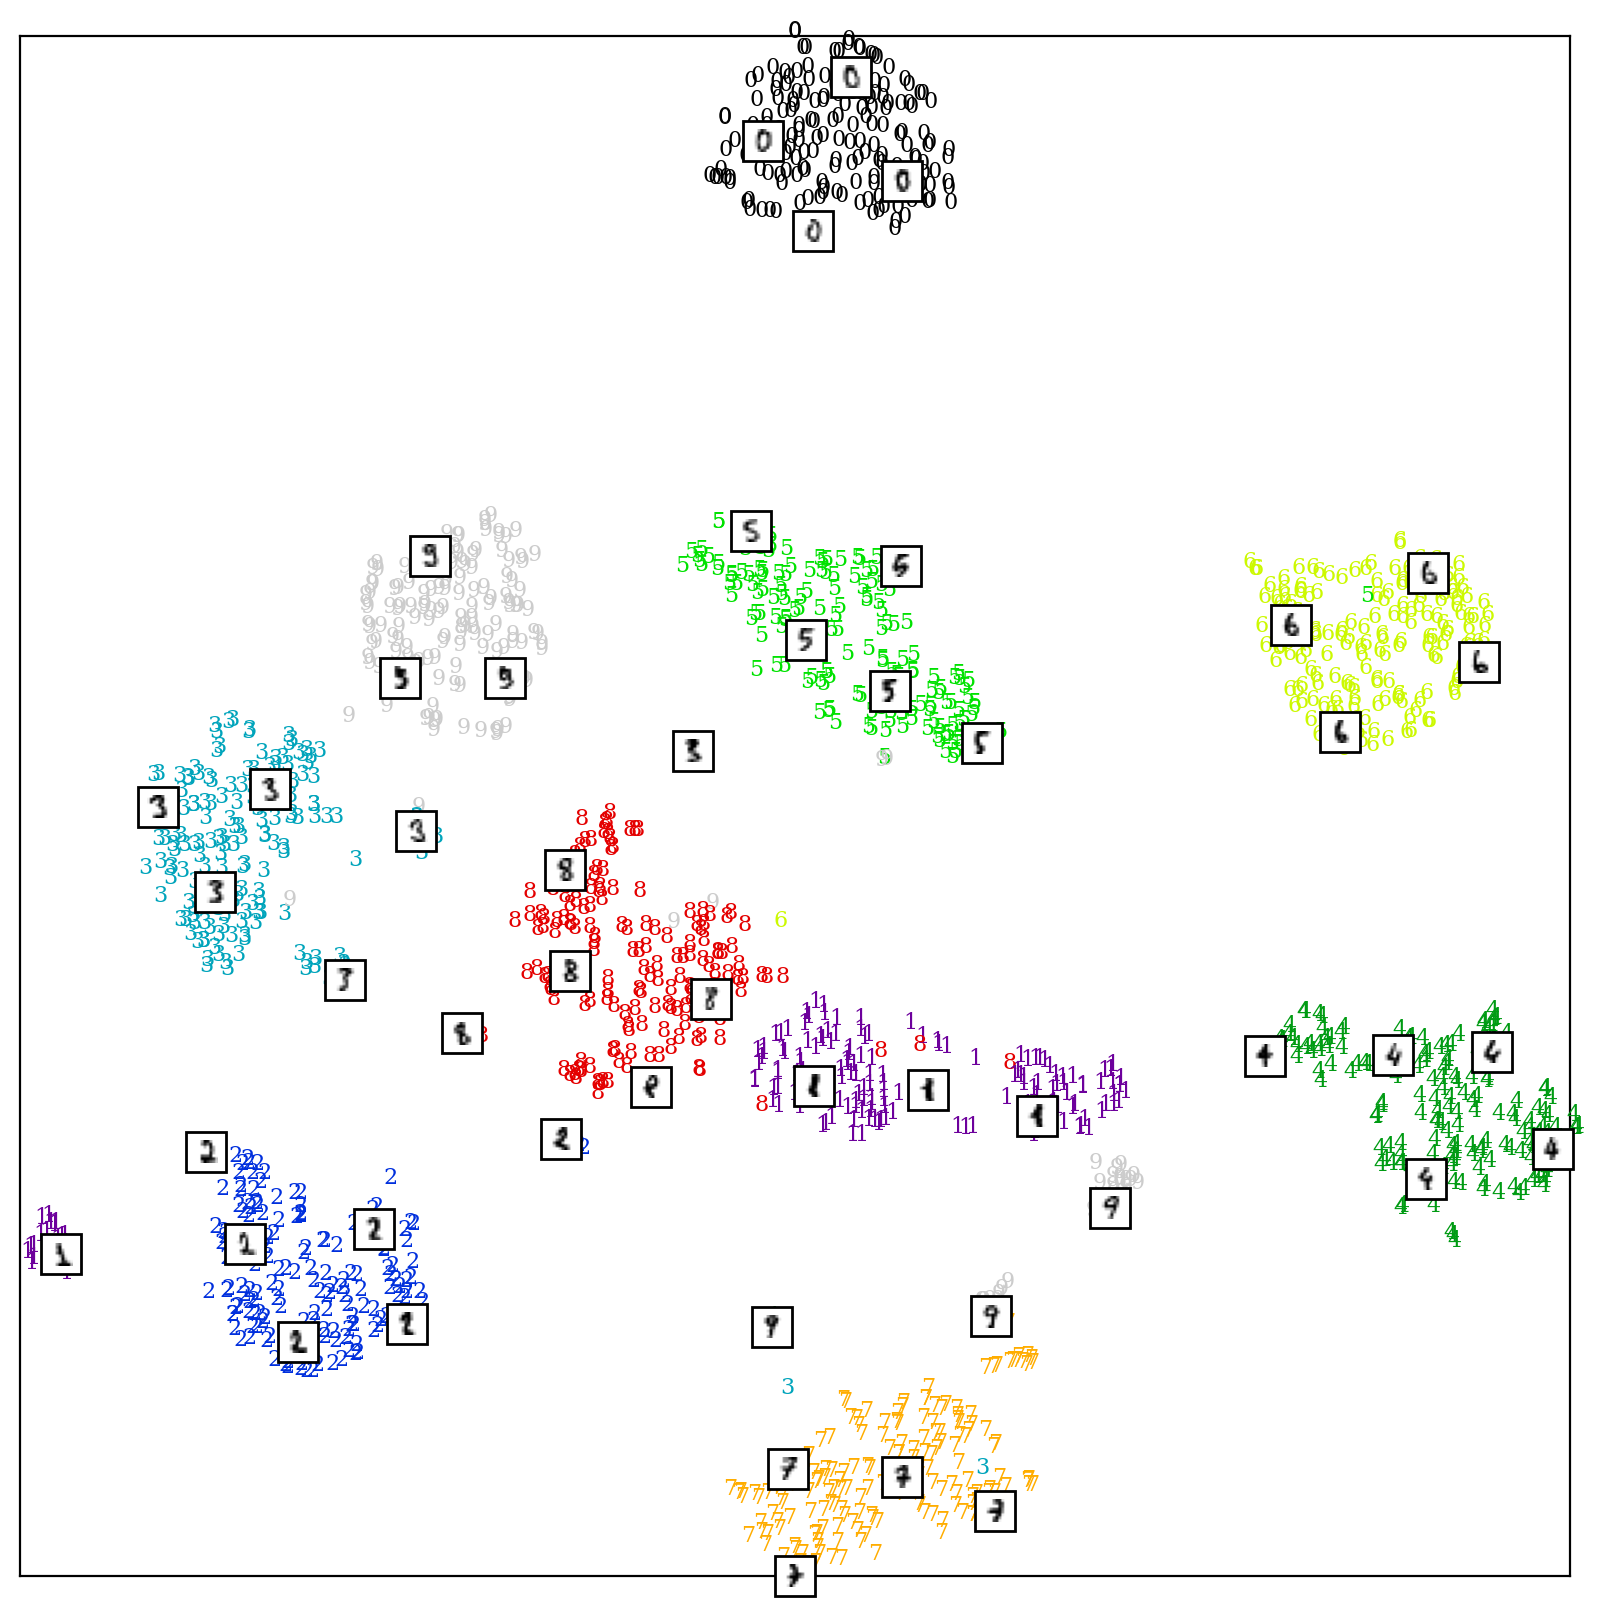

In [15]:
# Execute this cell
from matplotlib import offsetbox

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]), 
                 color=plt.cm.nipy_spectral(y[i]/9.))

    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(digits.data.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i],
                                  cmap=plt.cm.gray_r), 
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
plot_embedding(X_reduced)
plt.show()

Is this cool or what?!

One other reason why t-SNE is so powerful is that while Isomap, LLE and variants are best suited to unfold a single continuous low-dimensional manifold, t-SNE groups samples based on the local structure. So it can be used to unwrap and disentangle a dataset that comprises several manifolds at once (as is the case in the digits dataset). See [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) for more details.

Here is another fun example of **t-SNE used to visualize one realization of the Netflix catalog** (from https://lvdmaaten.github.io/tsne/). So if you have trouble finding something to watch, look here for something you already enjoy then check out its neighboors.

![](https://lvdmaaten.github.io/tsne/examples/netflix_tsne.jpg)

### Drawbacks of non-linear embeddings tecniques

- **Noisy and gappy data**. For our S problem, imagine a point at x=0,y=0 but unconstrained in z. The algorithm cannot possibly know where to put it on the S. Manifold learning tecniques are intrisically bad for missing data. 
- **Tuning parameters**. Sophisticated things needs to be tuned (I didn't even mention the learning rate parmeter in t-SNE!)
- **Dimensionality**. In PCA, the eigenvalue give you a sense of the intrinsic dimensionality, i.e. how many dimensions you should keep. This is not the case with non-linear approaches.
- **Outliers** can be a big problem for these tools. There's a nice example on this in Fig 7.9 in the textbook. If you look at the code, the first have to filter out outliers with a different algorithm before applying LLE successfully.
- **Reconstruction**. Non-linear mapping does not provide a set of basis function like PCA, making data reconstruction  less clean (need to use e.g. nearest neighbors).

## Better Dataviz

We often use dimensionality reduction to help with data visualization, so it seems appropriate to briefly talk about some different ways to improve our data visualization using plotting tools. 

This is an illustration of the power of [Bokeh](https://bokeh.org/), a language to create interacte browser-based dashboards for data visualization. The following cell will create and launch a new browser tab (chrome for me) that shows a set of interactive scatter plots for the penguin data set. This uses the data-visualization principles of [**brushing & linking**](https://www.wikiwand.com/en/Brushing_and_linking).

- ***Linking*** refers to having a connected series of data representations (e.g. histograms or scatter plots), where a change in one parameter or a subset of parameters in one representation is then reflected in the others.
- ***Brushing*** refers to highlighting subsets of data within one representation such that this subset is also highlighted in its other representations through the linked view.

In [20]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
from bokeh.plotting import *
from bokeh.models import ColumnDataSource

# prepare some data
N = 300
x0 = penguins['bill_depth_mm']
x1 = penguins['flipper_length_mm']
y = penguins['body_mass_g']
species = penguins['species']

# output to static HTML file
output_file("linked_brushing.html")

# NEW: create a column data source for the plots to share
source = ColumnDataSource(data=dict(x0=x0, x1=x1, 
                                    y=y, species=species))

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select"

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("species", "@species"),
]

# create a new plot and add a renderer
left = figure(tools=TOOLS, tooltips=TOOLTIPS, 
              width=350, height=350, title=None,
              x_axis_label ="bill_depth_mm",
              y_axis_label ="body_mass_g")
left.circle('x0', 'y', source=source)

# create another new plot and add a renderer
right = figure(tools=TOOLS, tooltips=TOOLTIPS, 
               width=350, height=350, title=None,
              x_axis_label ="flipper_length_mm",
               y_axis_label ="body_mass_g")
right.circle('x1', 'y', source=source)

# put the subplots in a gridplot
p = gridplot([[left, right]])

# show the results
show(p)

### Excercise for home
Implement a bokeh visualization in our of the excercises we've done so far (for instance the GRB one, or the digits above) and see if you find something new

If you're interested in data visualization and in general scientific reporting, have a look into the work of [Edward Tufte](https://en.wikipedia.org/wiki/Edward_Tufte) and his most famous book called "[Beautiful Evidence](https://yuriweb.com/tufte/)" 

![](https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1392420570l/17743.jpg)


# Ok. Where do we stand? Recap

![](https://scikit-learn.org/stable/_static/ml_map.png)

We've covered both unsupervised processes so far: **clustering** and **dimensionality** reduction.

**Density estimation** is also part of unsupervised learning. We've seen all these things already, but I will recap them all here, so you have everything in the same place when studying.

## Density Estimation <a class="anchor" id="one"></a>

Inferring the pdf of a sample of data is known as ***density estimation***. Essentially we are smoothing the data to correct for the finiteness of our sample and to better recover the underlying distribution.

We have seen some hints in a previous lectures where we discussed histogram bins and KDEs. Let's recap and expand here.


Density estimation is useful because:
- identifying low probability regions can help uncover rare sources. 
- if the data can be divided into sub-samples, one can estimate the pdf for each subsample and, in turn determine classifications for new objects.

### Non-parametric Density Estimation <a class="anchor" id="onea"></a>

*Nonparametric* density estimation is useful when we know nothing about the underlying distribution of the data, since we don't have to specify a functional form. This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

#### Kernel Density Estimation (KDE)

[*Kernel Density Estimation (KDE)*](https://en.wikipedia.org/wiki/Kernel_density_estimation) is the standard approach for non-parametric density estimation.

Let's start by recalling some problems with making simple histograms.

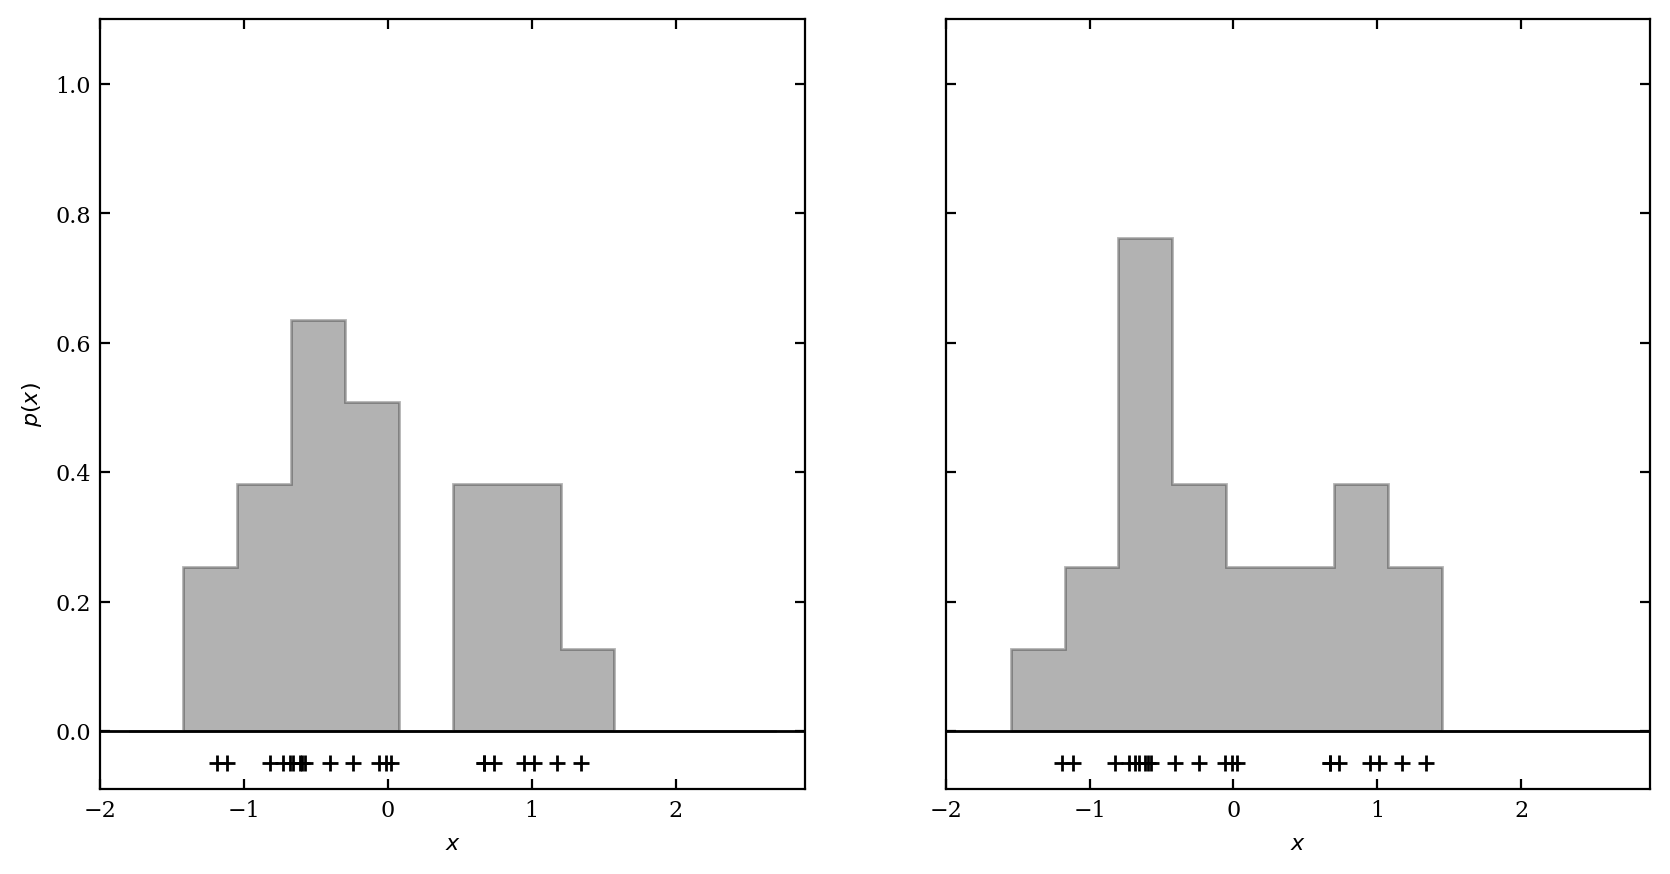

In [21]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Draw some random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), 
                    np.random.normal(1, 0.3, size=7)])


# Modified from Ivezic, Figure 6.1, modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#------------------------------------------------------------

# First figure: silly histogram binning
fig1 = plt.figure(figsize=(10, 5))
#fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
#                    bottom=0.15, top=0.9, hspace=0.05)

FC = '#6666FF'
XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()

The data points that make up the histogram are the same in both panels.  All we have done is shifted the locations of the bins by 0.25. ***The choice of number of bins and the location of bin centers can really change the histogram that we make.***

The next panels are what happens if we center the bins on each point. This is an example of **kernel density estimation** using a "***top-hat***" kernel. It is a good description of the data, but pretty ugly.

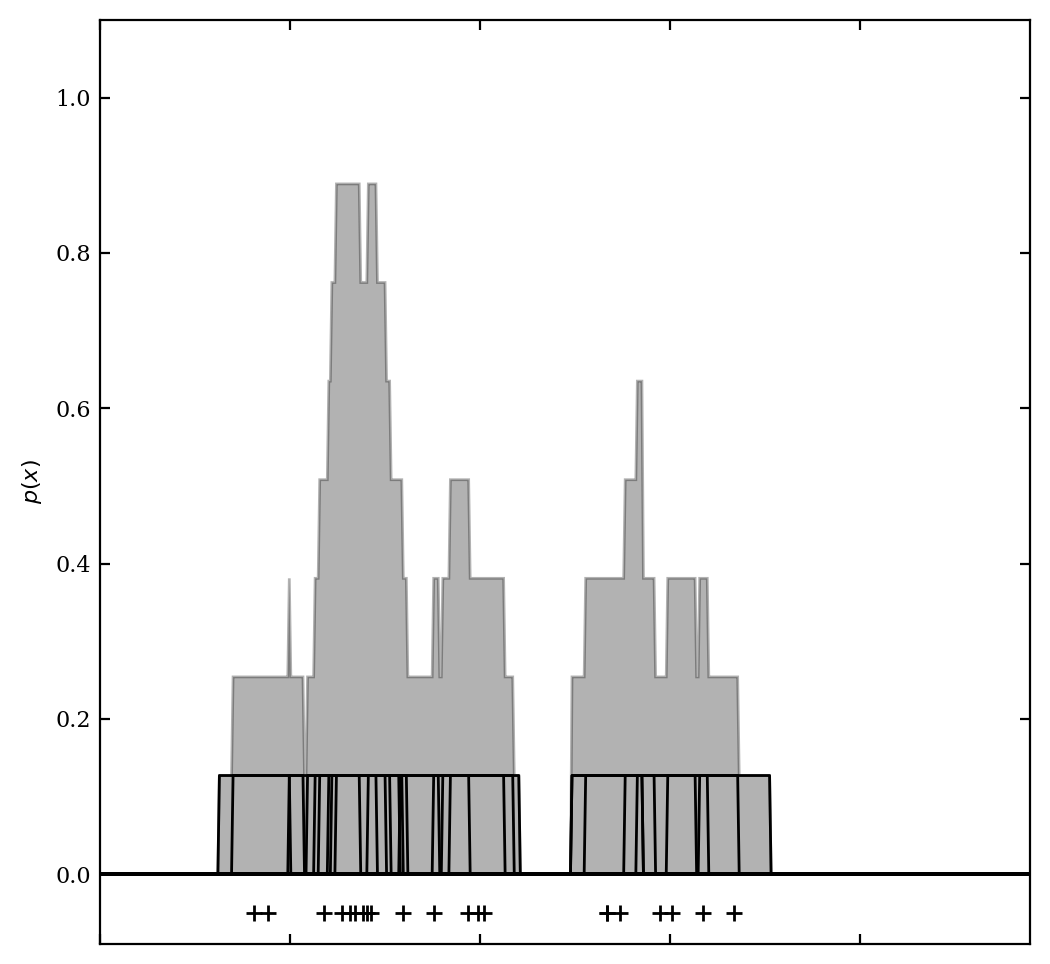

In [22]:
fig1b = plt.figure(figsize=(6, 6))
#fig1b.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
#                     bottom=0.1, top=0.95, hspace=0.05)

ax = fig1b.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')

plt.show()

We can make it look nicer by choosing a different kernel, i.e. a different bin shape. The next plot shows a **KDE using a Gaussian kernel**.



Text(0, 0.5, '$p(x)$')

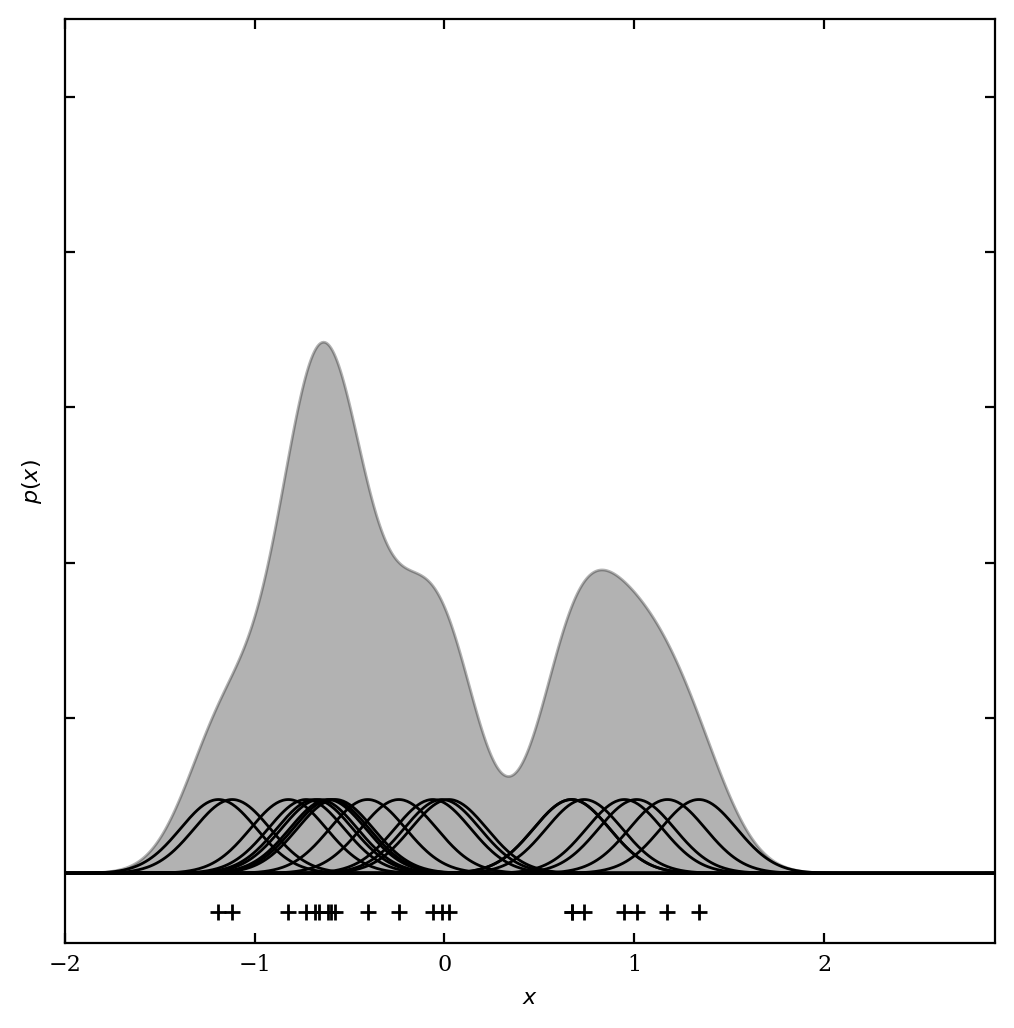

In [27]:
#------------------------------------------------------------
# First figure: transition to KDE
fig2 = plt.figure(figsize=(6, 6))
#fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
#                     bottom=0.0, top=1.0, hspace=0.05)

## Just right
ax = fig2.add_subplot(111)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

We can think of KDE as replacing the points with "clouds". Each cloud is described by the kernel $K(u)$, where $K(u)$ can be any function that is:
- smooth,
- postive definite,
- normalizes to unity, 
- has zero mean,
- has positive variance. 

A common kernel is the **Gaussian kernel** that we just used above:

$$ K(u) = \frac{1}{(2\pi)^{D/2}}\exp{(-u^2/2)}$$

where $D$ denotes the dimensionality of the data. Once a kernel is chosen the KDE at a point, $x$, is given by 

$$ \hat{f}(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$

where $\hat{f}$ is an ***estimator*** of our distribution.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$. Normally $d(x,x_i) = (x-x_i)$. For the gaussian kernel that makes $h=\sigma$. So, $h$ represents the "width" or what is usually called the **"bandwidth"** in this context.

**The Epanechnikov kernel is "optimal" because it minimizes the variance of the kernel density estimate**: 

$$K(x) = \frac{3}{4}(1-x^2),$$

for $|x|\le 1$ and 0 otherwise. Below is the code that produces the plot above.  


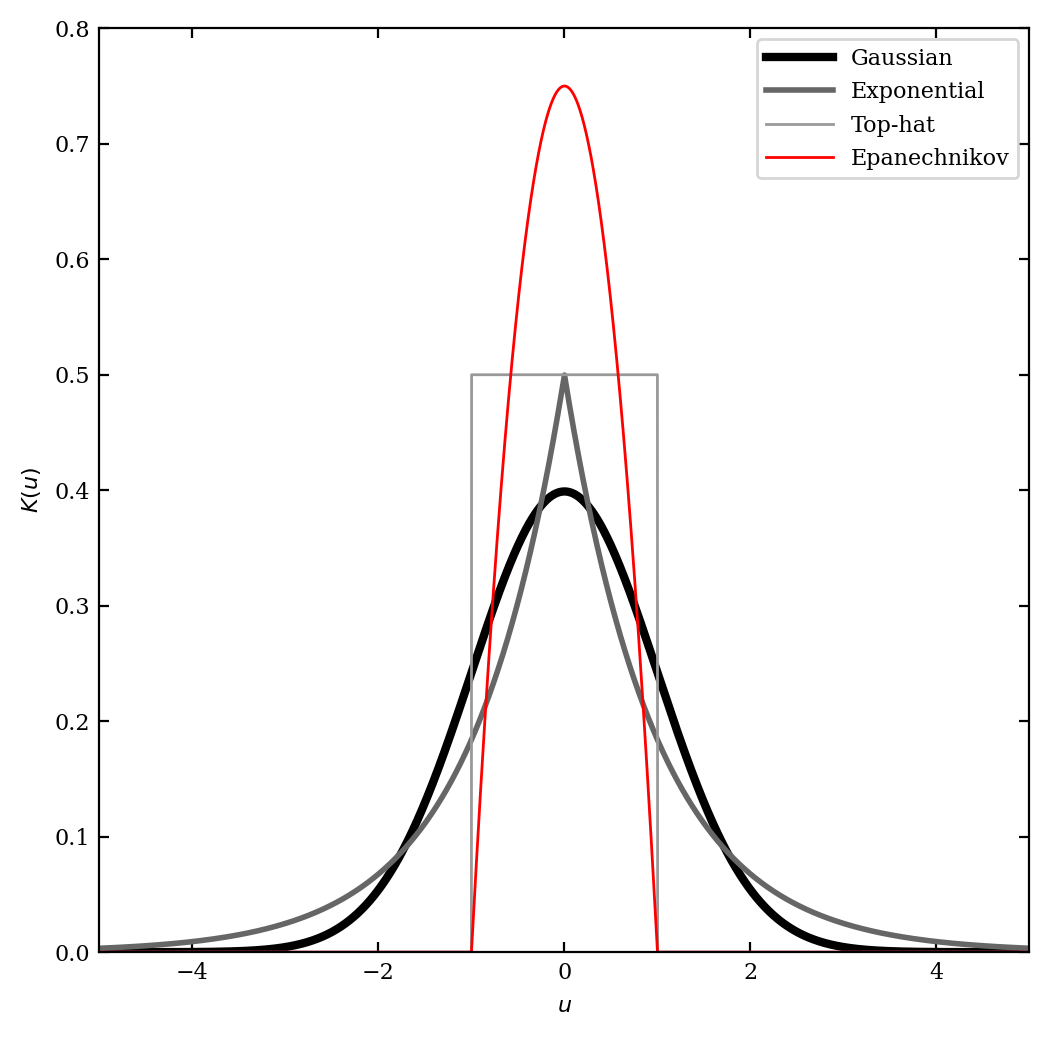

In [28]:
#------------------------------------------------------------
# Compute Kernels.
xgrid = np.linspace(-5, 5, 10000)
dx = xgrid[1] - xgrid[0]

# Gaussian kernel
gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * xgrid ** 2)

# Exponential kernel
exp = 0.5 * np.exp(-abs(xgrid))

# Top-hat kernel
tophat = 0.5 * np.ones_like(xgrid)
tophat[abs(xgrid) > 1] = 0 # Range of the tophat kernel

# Epanechnikov kernel 
ep = 3/4 * (1-xgrid**2)  # Add the Epanechnikov kernel function
ep[np.abs(xgrid)>1] = 0 # Set the range of the kernel

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(xgrid, gauss, '-', c='black', 
        lw=3, label='Gaussian')
ax.plot(xgrid, exp, '-', c='#666666', 
        lw=2, label='Exponential')
ax.plot(xgrid, tophat, '-', c='#999999', 
        lw=1, label='Top-hat')
# Add the Epanechnikov kernel to the plot
ax.plot(xgrid, ep, '-', c='red', 
        lw=1, label='Epanechnikov')  

ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.8001)
plt.show()

#### How do we determine the optimal kernel bandwidth?

You know the answer to this one already: ***cross validation**. Go back to lecture 14.



0.14655172413793105


(-0.09, 1.1)

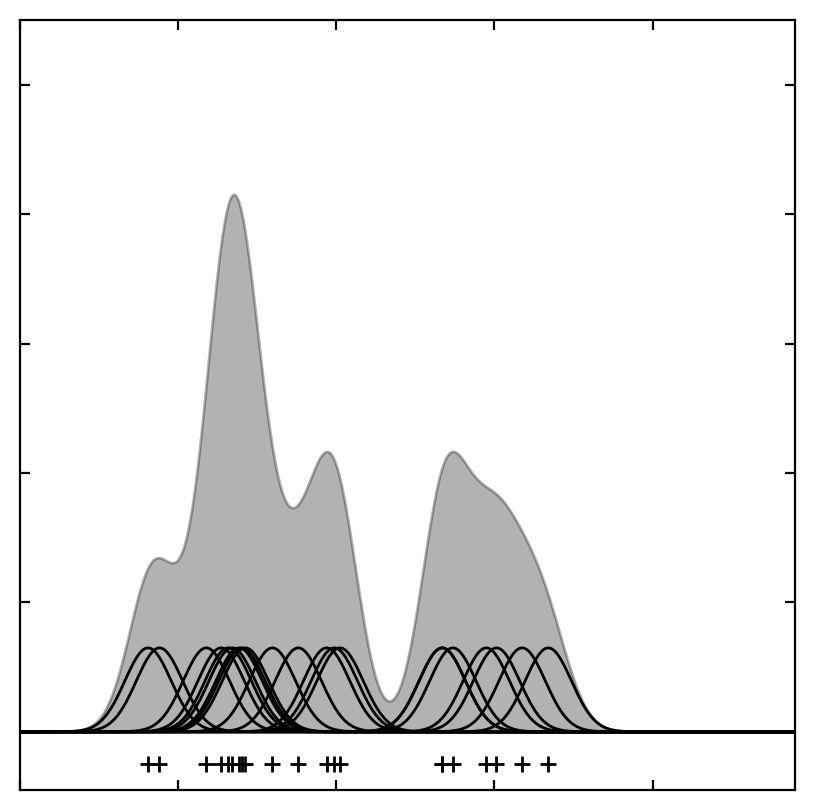

In [29]:
# Complete and Execute this cell to determine the bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01,1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
# print(bwrange)
K = 10 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

binwidth = bins[1] - bins[0]
x_grid = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_grid, x[:, None], h_opt)
y_plot /= (binwidth * len(x))

ax.fill(x_grid, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_grid, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')

ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

#### 2-D distributions

Here is some sample code using [`sklearn.neighbors.KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). Play around with this and see how it works.  Make different variations of the plot.  (For example, try `bandwidth=0.01` and `bandwidth=1.0`.)  What we are doing here is using KDE to set the plot color to indicate the relative density of the points.  This is essentially a 2-D histogram.

/tmp/ipykernel_14664/1345506922.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


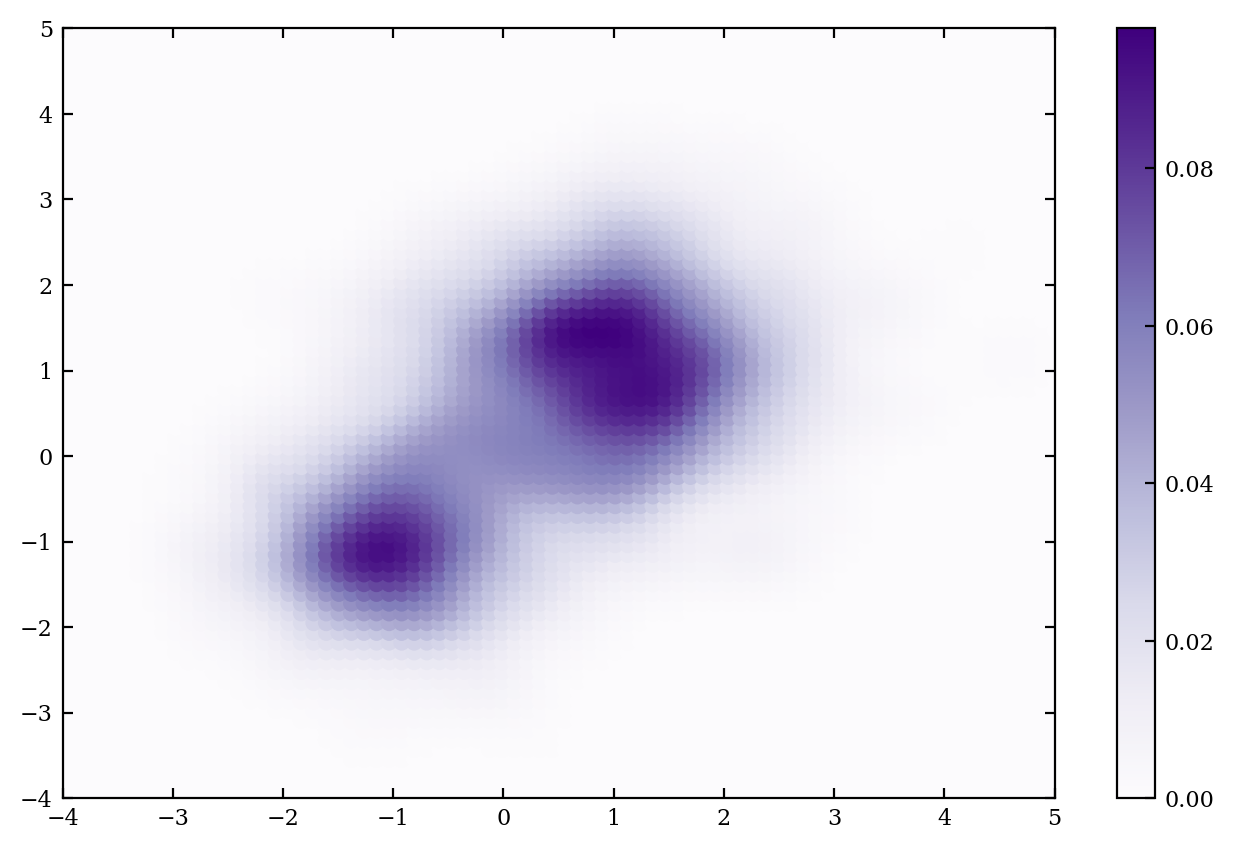

In [37]:
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(500,2)), 
                    np.random.normal([1,1],[1,1], size=(1000,2))]) 
kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

We now want do a data-driven selection of the bandwidth. That's a cross validation on a 2d KDE, which sounds complicated. Actually, look at how easy this is! Just copy the example from above to a new cell and splice in the cross validation code to produce a new plot with the "optimal" bandwidth. Basically, splice in the lines of code for `GridSearchCV` between the lines setting `X` and instantiating `kde`.  Then replace the hardcoded bandwidth with the optimal value you computed.

That's it really, and it just works. This is a good example on how modern python libraries can really make you data-science life so much easier!

[0.01       0.04413793 0.07827586 0.11241379 0.14655172 0.18068966
 0.21482759 0.24896552 0.28310345 0.31724138 0.35137931 0.38551724
 0.41965517 0.4537931  0.48793103 0.52206897 0.5562069  0.59034483
 0.62448276 0.65862069 0.69275862 0.72689655 0.76103448 0.79517241
 0.82931034 0.86344828 0.89758621 0.93172414 0.96586207 1.        ]
0.38551724137931037


/tmp/ipykernel_14664/2255228857.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


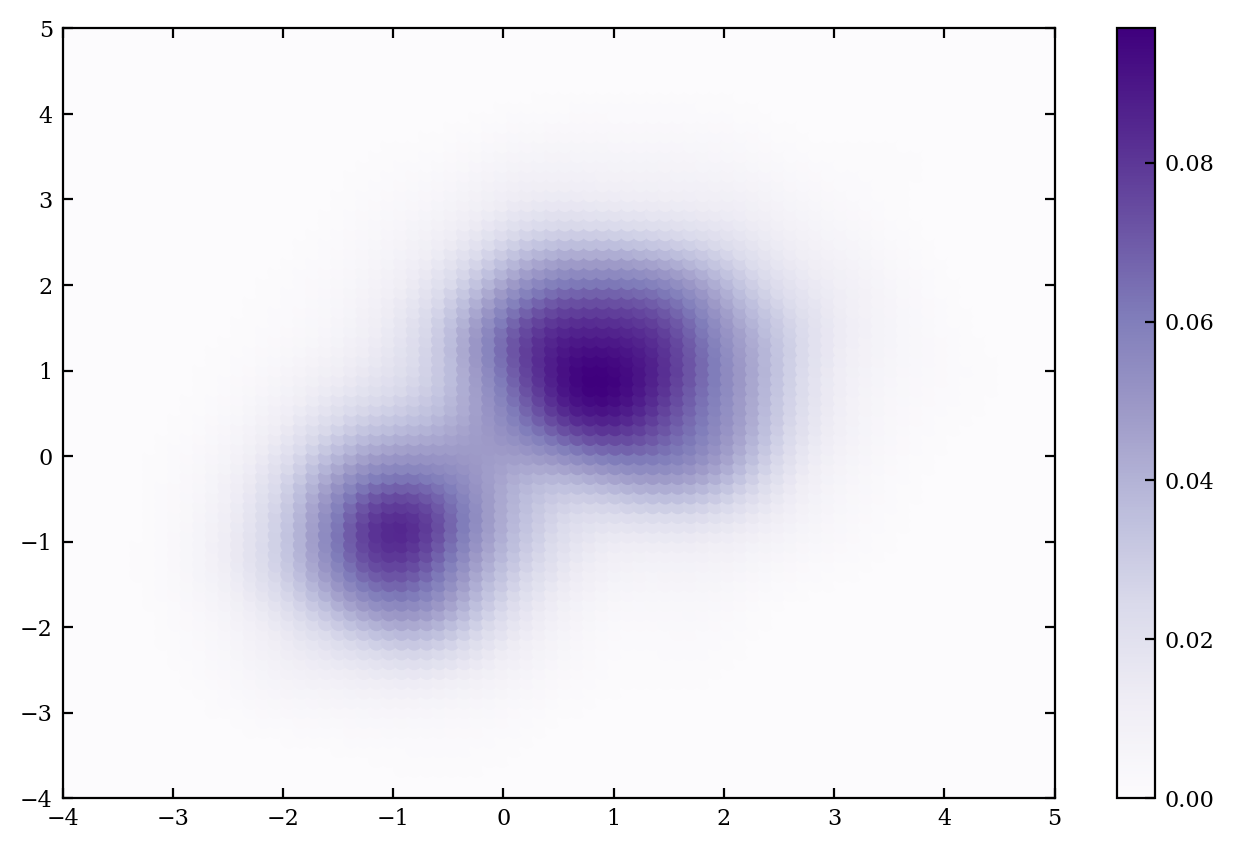

In [41]:
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(500,2)), 
                    np.random.normal([1,1],[1,1], size=(1000,2))]) 


#### I pasted from here...
bwrange = np.linspace(0.01,1.0, 30)
print(bwrange)
K = 10 
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(X)
h_opt = grid.best_params_['bandwidth']
print(h_opt)
### ... to here


kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) # Changed here.
kde.fit(X) 

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()



---

#### Nearest-Neighbor Density Estimation

Another very simple way to estimate the density of an $N$-dimensional distribution is to look to the nearest object (or the $K$ nearest objects) and compute their distances, $d_K$.  This is the [$K$-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm. The density at a given point, $x$ is estimated as

$$\hat{f}_K(x) = \frac{K}{V_D(d_K)},$$

where $V_D(d)$ is given generically by $\frac{2d^D\pi^{D/2}}{D\Gamma(D/2)}$ where $\Gamma$ is the complete gamma function, and this formula reduces to the usual equations for area and volume in 2 and 3 dimensions, respectively.

We can simplify this to 

$$\hat{f}_K(x) = \frac{C}{d_K^D}$$

since the constant, $C$ can be evaluated at the end.

This estimator has some intrinsic bias, which can be reduced by considering *all* $K$ nearest neighbors:
$$\hat{f}_K(x) = \frac{C}{\sum_{i=1}^K d_i^D}$$

See the [Scikit-Learn `neighbors` documentation](http://scikit-learn.org/stable/modules/neighbors.html) for more information.

Ivezic, Figure 6.5 compares a Nearest Neighbor ($k=10$) with a KDE algorithm. Let's what happens as you increase the number of neighbors used.

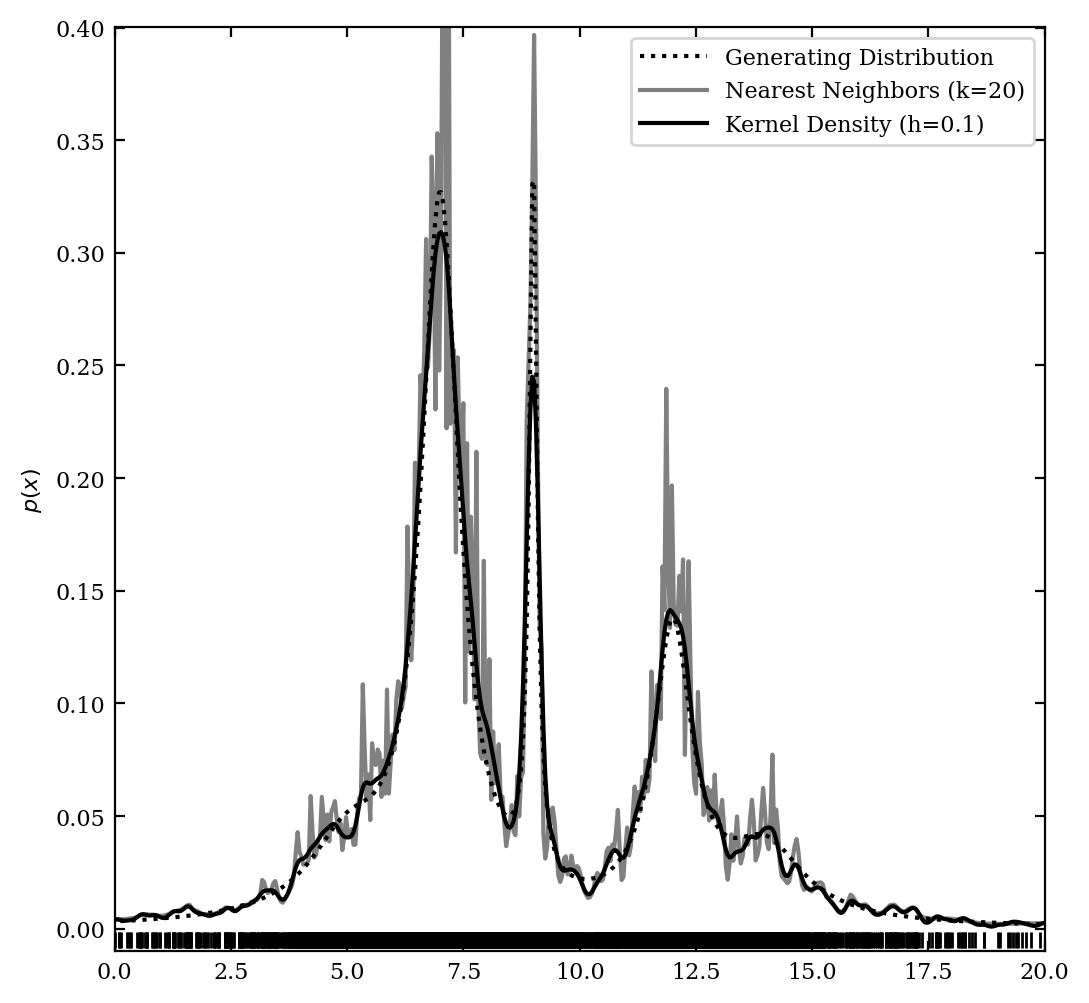

In [49]:
# Based on Ivezic, Figure 6.5
# Modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) 
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N)) 
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(6, 6))
N = 5000
k = 20 #Number of neighbors

xN = x[:N]
t = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xN[:, None])
dens_kde = np.exp(kde.score_samples(t[:, None]))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

# plot the results
plt.plot(t, true_pdf(t), ':', color='black', 
         zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='black', 
         zorder=3, label="Kernel Density (h=0.1)")

# label the plot
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)

plt.show()

### Parametric Density Estimation <a class="anchor" id="oneb"></a>

#### Gaussian Mixture Models (GMM)

We've done an excercise on this already, so let me recap this quickly for completeness. KDE centers each bin (or rather, kernel) at each point.  In a [**mixture model**](https://en.wikipedia.org/wiki/Mixture_model) we don't use a kernel for each data point, but rather we fit for the ***locations of the kernels*** in addition to the width. So a mixture model is sort of a hybrid between a traditional (fixed bin location/size) histogram and KDE. 

- Using lots of kernels (maybe even more than the AIC or BIC score suggests) may make sense if you just want to provide an accurate description of the data (as in density estimation).  
- Using fewer kernels makes mixture models more like clustering (see earlier lecture), where the suggestion is still to use many kernels in order to divide the sample into real clusters and "background".

Gaussians are the most commonly used components for mixture models.  So, the pdf is modeled by a sum of Gaussians:

$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$

where $\alpha_k$ are the "mixing coefficients" with $0\le \alpha_k \le 1$ and $\sum_{k=1}^N \alpha_k = 1$.

We can solve for the parameters using maximum likelihood analyis as we have discussed previously.
However, this can be complicated in multiple dimensions, requiring the use of [**Expectation Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) methods (see textbook for details).

Ivezic Figure 4.2 (next cell) provides an example in 1-D.

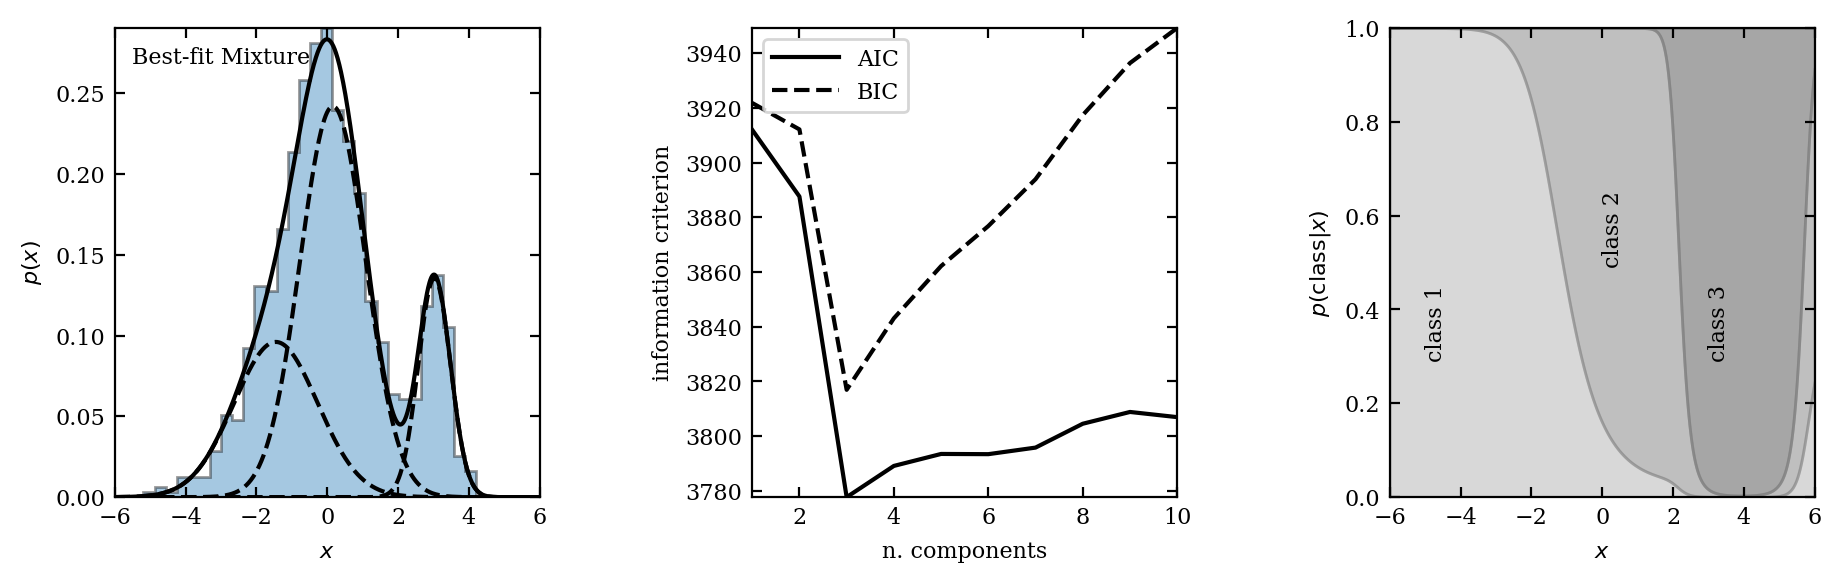

In [50]:
# Ivezic v2, Figure 4.2
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

### Datasets you can play with

If irises, penguins, or hand-written digits aren't your thing, then have a look through some of these public data repositories. Explore!

- [https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer](https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)
- [http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739](http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739)
- [http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html](http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html)

# And now... Pills of modern research with two professional astrostatisticians!

For today I've invited two of my scientific collaborators to give you some examples on how current astrophysical problems are tackled not just using, but also *developing* new statistical tools:  

- Viola De Renzis [Slides](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/lectures/T01_DeRenzis.pdf)
- Costantino Pacilio [Slides](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/lectures/T02_Pacilio.pdf)
 



If you want more, last year's "pill of modern research" were given by

- Matthew Mould. [Slides](https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/lectures/T01_Mould.pdf)
- Riccardo Buscicchio. [Slides](https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/lectures/T02_Buscicchio.pdf)